## Installs and Imports

In [8]:
import re
import string
import subprocess
import sys
import warnings

warnings.filterwarnings('ignore')

REQS = [
    ('pip', 'pip==24.2'),
    ('lightgbm', 'lightgbm==4.5.0'),
    ('matplotlib', 'matplotlib==3.9.2'),
    ('mlxtend', 'mlxtend==0.23.1'),
    ('nltk', 'nltk==3.9.1'),
    ('numpy', 'numpy==2.0.2'),
    ('optuna', 'optuna==4.0.0'),
    ('pandas', 'pandas==2.2.2'),
    ('seaborn', 'seaborn==0.13.2'),
    ('sklearn', 'scikit-learn==1.5.2'),
    ('statsmodels', 'statsmodels==0.14.3'),
    ('umap-learn', 'umap-learn==0.5.6'),
    ('xgboost', 'xgboost==2.1.1'),
]

try:
    subprocess.check_call([sys.executable, '-m', 'ensurepip'])
except Exception as e:
    print(e, file=sys.stderr)


def ensure_installed(module_info):
    _, install_str = module_info
    try:
        subprocess.check_call([sys.executable, '-m',
                               'pip', 'install', '--quiet',
                               install_str])
        print(f'Installed "{install_str}".')
    except Exception as e:
        print(e, file=sys.stderr)


for m in REQS:
    ensure_installed(m)

# Standard libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Machine learning and data processing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    calinski_harabasz_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    silhouette_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Statistical modeling
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Dimensionality reduction
import umap

# Hyperparameter optimization
import optuna

# Other machine learning libraries
import lightgbm as lgb
from xgboost import XGBClassifier
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


def find_columns_with_missing(data, columns):
    """Finding features that have a lot of missing data"""
    print()
    print('Finding columns with missing data...')
    data_cleaned = data
    missing = []
    i = 0
    for col in columns:
        missing.append(data[col].isnull().sum())
        if missing[i] > 0:
            print()
            print(f'Column {col} is missing {missing[i]} values.')
            print(f'Proportion of missing data is {missing[i]/len(data)}.')
            if missing[i]/len(data) >= 0.9:
                print(f'Dropping column {col}...')
                data_cleaned = data_cleaned.drop(columns=col)
        i += 1
    return missing, data_cleaned


def hex_to_rgb(hex_color):
    """Function to convert hex to RGB"""
    # Remove the '#' if it exists
    hex_color = hex_color.lstrip('#')

    # Convert hex to integer and split into RGB components
    return [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]


def preprocess_text(text):
    """Preprocessing function"""
    text = text.lower()
    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removes punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    return ' '.join(tokens)


def plot_silhouette_bar_across_experiments(model_names, silhouette_scores):
    n_experiments = len(silhouette_scores)
    n_models = len(model_names)
    bar_width = 0.2
    index = np.arange(n_experiments)
    plt.figure(figsize=(12, 6))

    for i, model_name in enumerate(model_names):
        sil_scores = [exp_scores[i] for exp_scores in silhouette_scores]
        plt.bar(index + i * bar_width,sil_scores, bar_width, label=model_name)

    plt.xlabel('Experiments')
    plt.ylabel('Silhouette scores')
    plt.title('Silhouette scores Across Models and Experiments')
    plt.xticks(index + bar_width * (n_models - 1) / 2, [f'Exp {i+1}' for i in range(n_experiments)])
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_ch_index_across_experiments(model_names, ch_scores):

    n_experiments = len(ch_scores)
    n_models = len(model_names)
    bar_width = 0.2
    index = np.arange(n_experiments)
    plt.figure(figsize=(12, 6))

    for i, model_name in enumerate(model_names):
        ch_score = [exp_scores[i] for exp_scores in ch_scores]
        plt.bar(index + i * bar_width, ch_score, bar_width, label=model_name)

    plt.xlabel('Experiments')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title('Calinski-Harabasz Index Across Models and Experiments')
    plt.xticks(index + bar_width * (n_models - 1) / 2, [f'Exp {i+1}' for i in range(n_experiments)])
    plt.legend()
    plt.tight_layout()
    plt.show()


class KMeansClustering:
    def __init__(self, data):
        self.data = data
        self.best_params = None
        self.kmeans_model = None

    def tune_hyperparameters(self, n_trials=15):
        def objective_kmeans(trial):
            n_clusters = trial.suggest_int('n_clusters', 2, 10)
            init_method = trial.suggest_categorical('init', ['k-means++', 'random'])

            kmeans = KMeans(n_clusters=n_clusters, init=init_method, random_state=42)
            kmeans.fit(self.data)
            labels = kmeans.labels_
            score = silhouette_score(self.data, labels)
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective_kmeans, n_trials=n_trials)
        self.best_params = study.best_params
        print("Best params:", self.best_params)

    def fit_model(self):
        self.kmeans_model = KMeans(n_clusters=self.best_params['n_clusters'],
                                   init=self.best_params['init'],
                                   random_state=42)
        self.kmeans_model.fit(self.data)

    def visualize_clusters(self, umap_embedding, feature):
        labels = self.kmeans_model.labels_
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        # Scatter plot in 3D
        scatter = ax.scatter(
            umap_embedding[:, 0],
            umap_embedding[:, 1],
            umap_embedding[:, 2],
            c=labels,
            cmap='viridis',
            s=30
        )
        # Add labels and title
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        plt.title(f'3D UMAP of K-Means Clusters on {feature}')
        # Add a color bar for better visual distinction of clusters
        plt.colorbar(scatter)
        # Show the plot
        plt.show()

    def plot_elbow_method(self, k_range=(2, 10)):
        """
        Plot the Elbow Method for choosing the optimal number of clusters
        Args:
        - k_range: tuple, range of cluster numbers to evaluate
        """
        inertia = []
        K = range(k_range[0], k_range[1] + 1)
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.data)
            inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

        plt.figure(figsize=(8, 6))
        plt.plot(K, inertia, 'bo-', markersize=8)
        plt.title('Elbow Method for Optimal K')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia (Sum of squared distances)')
        plt.grid(True)
        plt.show()

    def output_label(self):
        return self.kmeans_model.labels_

    def silhoutte(self):
        score = silhouette_score(self.data, self.kmeans_model.labels_)
        print(f'The Silhouette score is {score}')
        return score

    def calinski(self):
        if len(np.unique(self.kmeans_model.labels_)) > 1:  # Only calculate if there are clusters
            score = calinski_harabasz_score(self.data, self.kmeans_model.labels_)
        else:
            score = np.nan  # If only one cluster (or all noise), set to NaN
        print(f'The Callinski index is {score}')
        return score


class DBSCANClustering:
    def __init__(self, data):
        self.data = data
        self.best_params = None
        self.dbscan_model = None

    def tune_hyperparameters(self, n_trials=15):
        def objective_dbscan(trial):
            eps = trial.suggest_float('eps', 0.1, 2.0)
            min_samples = trial.suggest_int('min_samples', 3, 20)

            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(self.data)
            labels = dbscan.labels_
            if len(set(labels)) > 1:
                score = silhouette_score(self.data, labels)
            else:
                score = -1
            return score

        study = optuna.create_study(direction="maximize")
        study.optimize(objective_dbscan, n_trials=n_trials)
        self.best_params = study.best_params
        print("Found best params:", self.best_params)

    def fit_model(self):
        self.dbscan_model = DBSCAN(eps=self.best_params['eps'], min_samples=self.best_params['min_samples'])
        self.dbscan_model.fit(self.data)

    def visualize_clusters_and_outliers_3D(self, umap_embedding, feature):
        labels = self.dbscan_model.labels_

        # Separate clustered points and noise points
        clustered_points = umap_embedding[labels >= 0]  # Points part of a cluster
        clustered_labels = labels[labels >= 0]
        outliers = umap_embedding[labels == -1]  # Noise points

        # Create a 3D plot
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the clustered points in different colors
        scatter = ax.scatter(clustered_points[:, 0], clustered_points[:, 1], clustered_points[:, 2],
                             c=clustered_labels, cmap='viridis', s=30)

        # Plot the outliers (noise points) in red with 'x' markers
        ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], c='red', marker='x', s=80, label='Outliers')

        # Add labels and title
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.set_title(f'DBSCAN 3D Clusters with Outliers on {feature}')
        # Add a legend and color bar for clusters
        plt.legend()
        plt.colorbar(scatter, ax=ax)
        plt.show()

    def output_label(self):
        return self.dbscan_model.labels_

    def silhoutte(self):
        score = silhouette_score(self.data, self.dbscan_model.labels_)
        print(f'The Silhouette score is {score}')
        return score

    def calinski(self):
        if len(np.unique(self.dbscan_model.labels_)) > 1:  # Only calculate if there are clusters
            score = calinski_harabasz_score(self.data, self.dbscan_model.labels_)
        else:
            score = np.nan  # If only one cluster (or all noise), set to NaN
        print(f'The Callinski index is {score}')
        return score


class ClusteringDataRetriever:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def get_data_with_labels(self):
        # If Data is in a numpy array, convert it to a pandas DataFrame
        if isinstance(self.data, np.ndarray):
            df = pd.DataFrame(self.data)
        else:
            df = self.data.copy()  # If already a DataFrame

        # Add a new column for the cluster labels
        df['Cluster_Label'] = self.labels

        return df[['gender', 'gender:confidence', 'Cluster_Label']]

    def get_cluster_data(self, cluster_label):
        # Retrieve data points belonging to a specific cluster.
        df = self.get_data_with_labels()
        return df[df['Cluster_Label'] == cluster_label]

    def get_noise_data(self):
        # Retrieve Records classified as noise (-1 label) in DBSCAN.
        return self.get_cluster_data(-1)

Installed "pip==24.2".
Installed "lightgbm==4.5.0".
Installed "matplotlib==3.9.2".
Installed "mlxtend==0.23.1".
Installed "nltk==3.9.1".
Installed "numpy==2.0.2".
Installed "optuna==4.0.0".
Installed "pandas==2.2.2".
Installed "seaborn==0.13.2".
Installed "scikit-learn==1.5.2".
Installed "statsmodels==0.14.3".
Installed "umap-learn==0.5.6".
Installed "xgboost==2.1.1".


## EDA


Dataset Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-nul

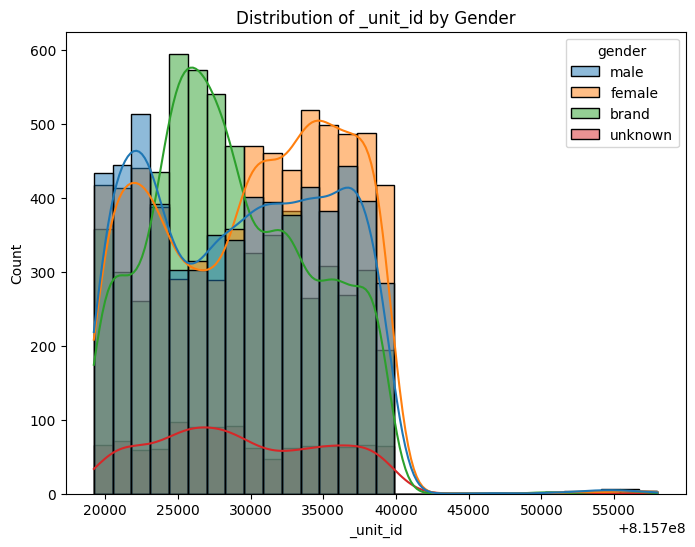

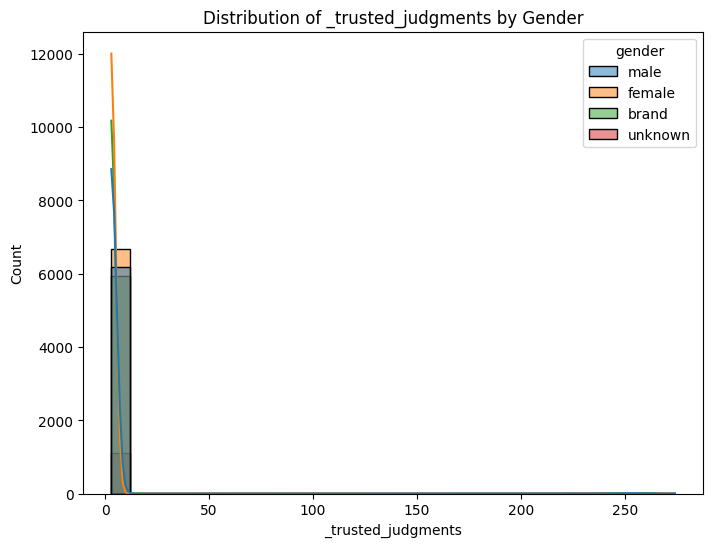

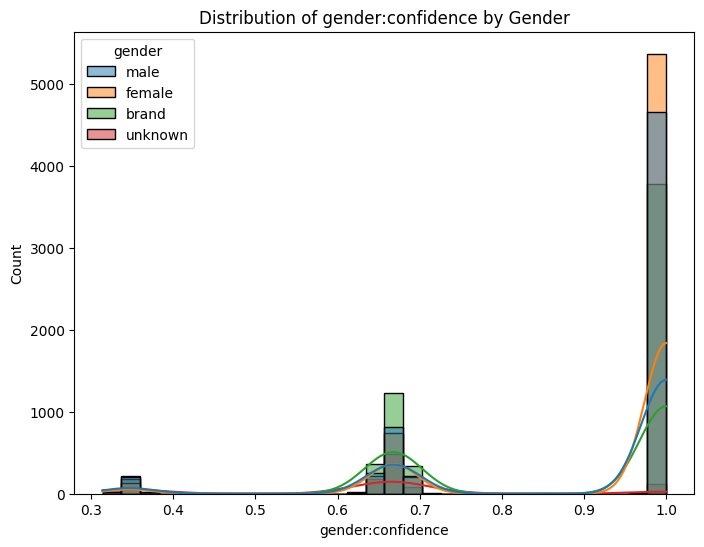

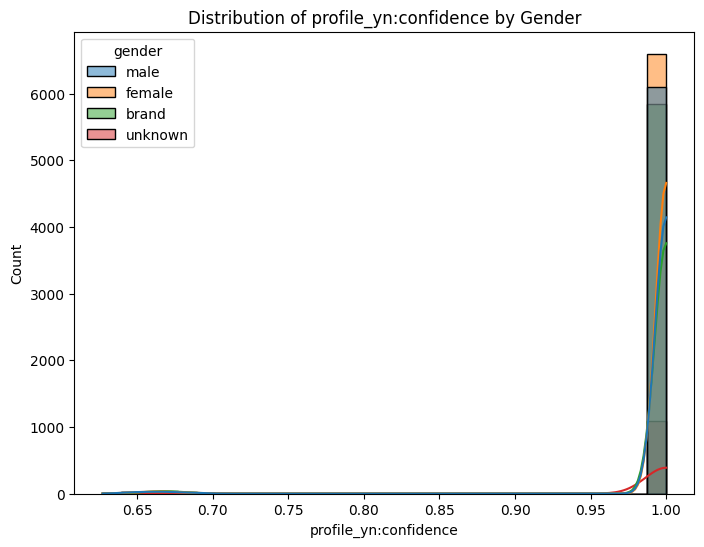

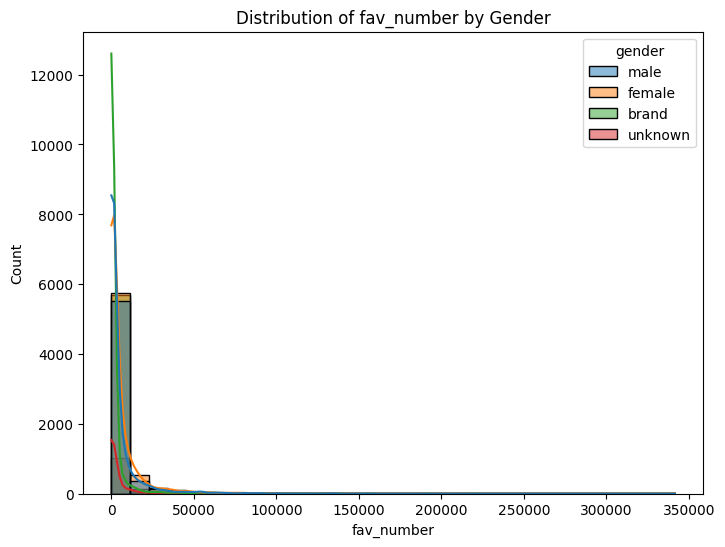

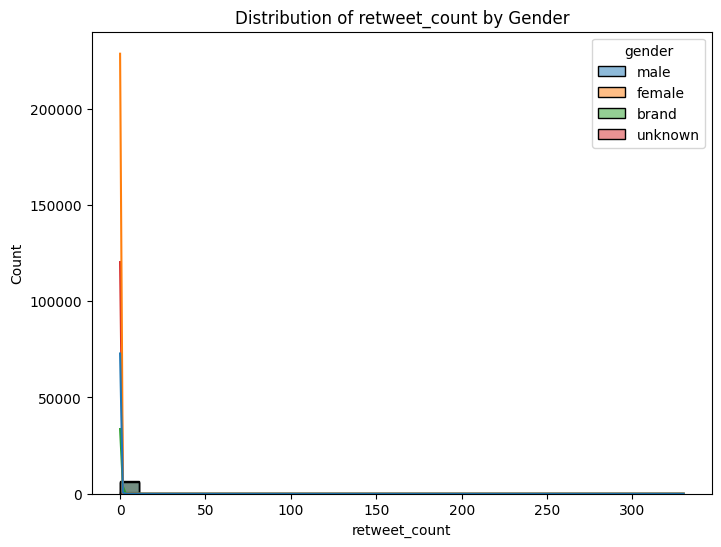

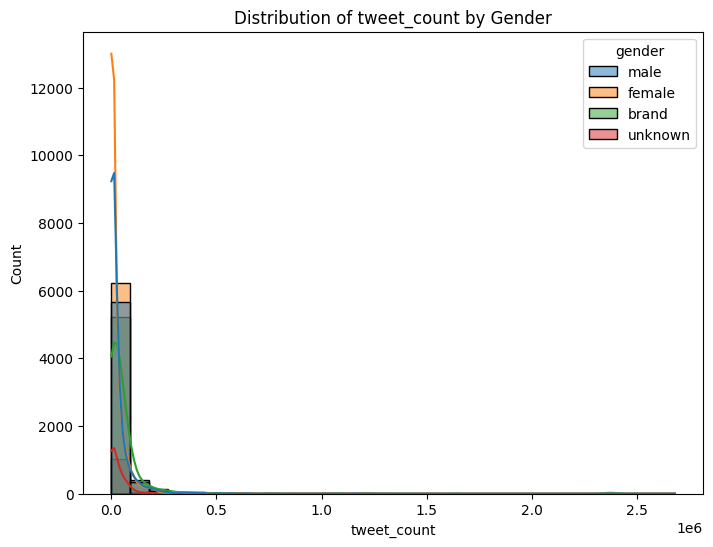

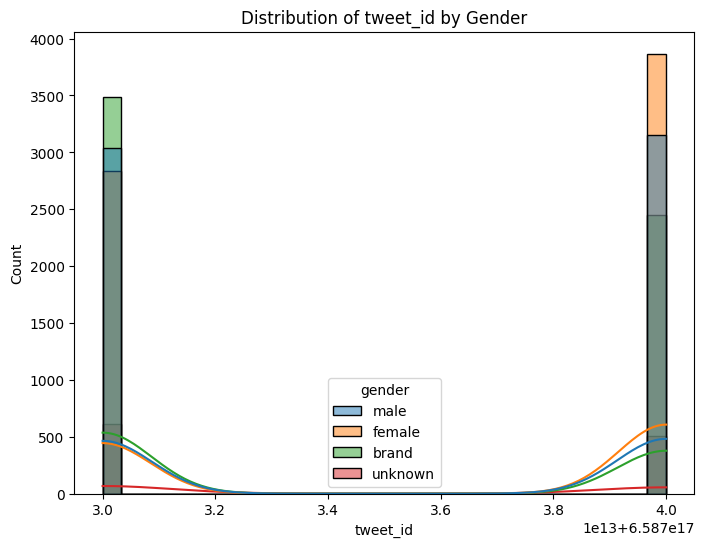

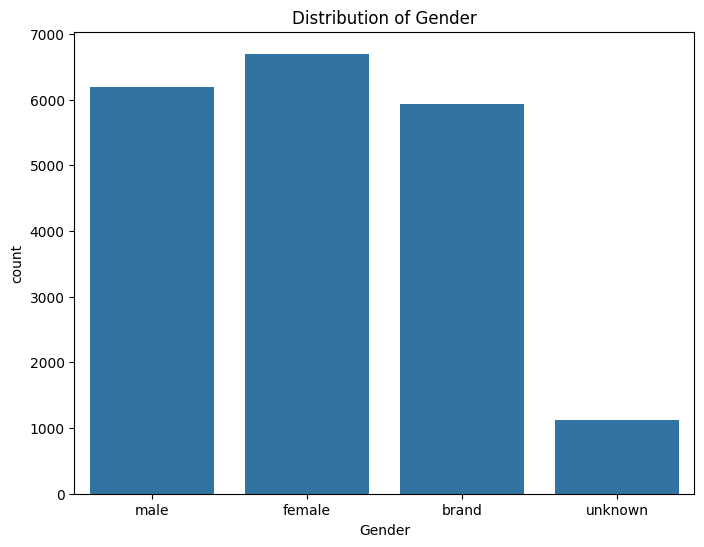

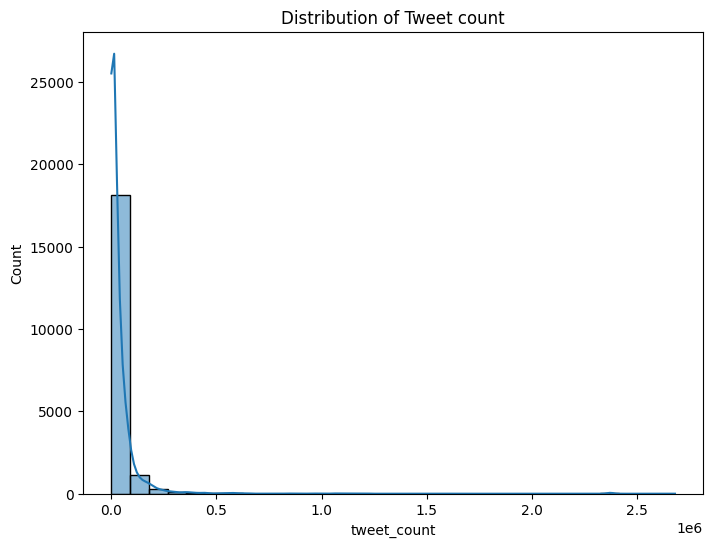

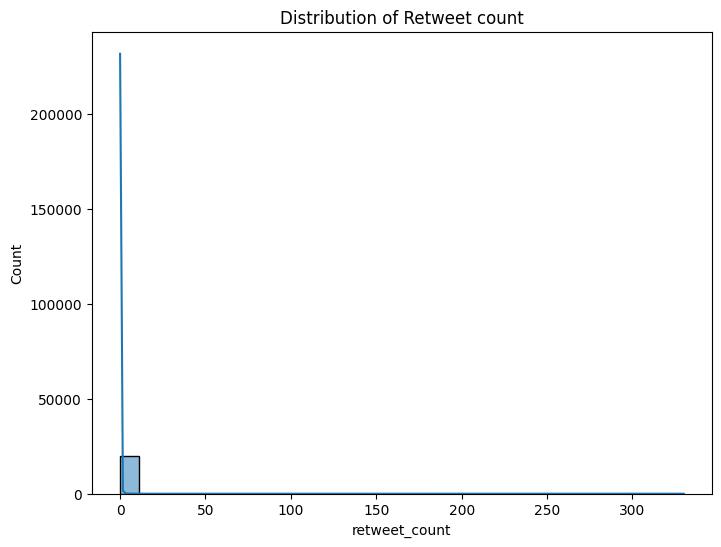

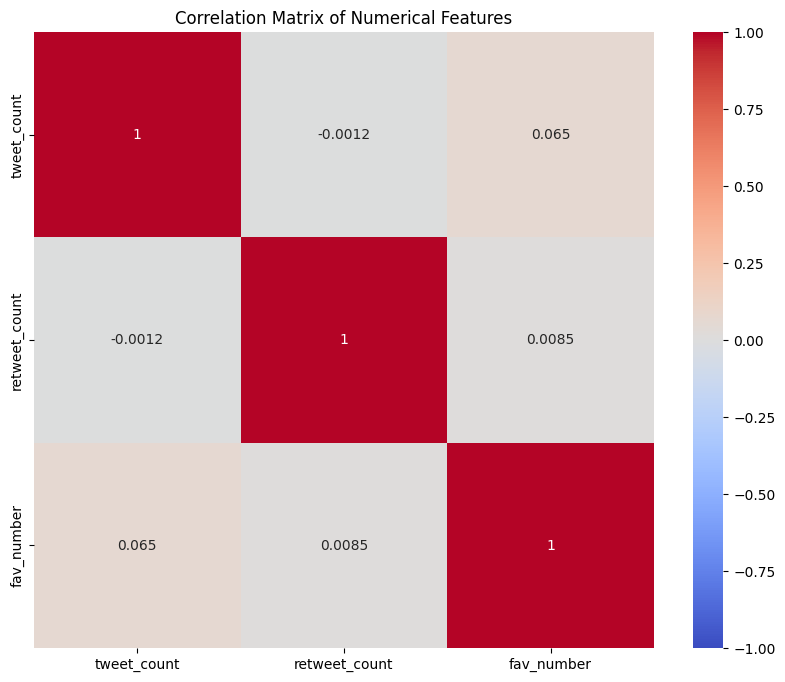

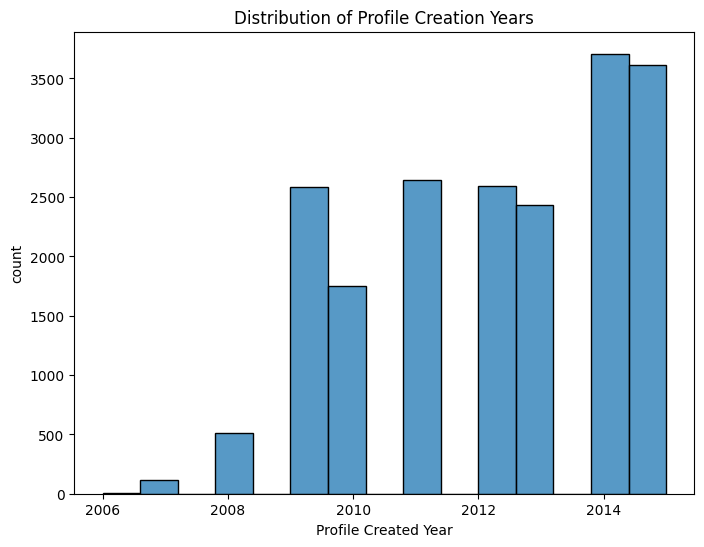

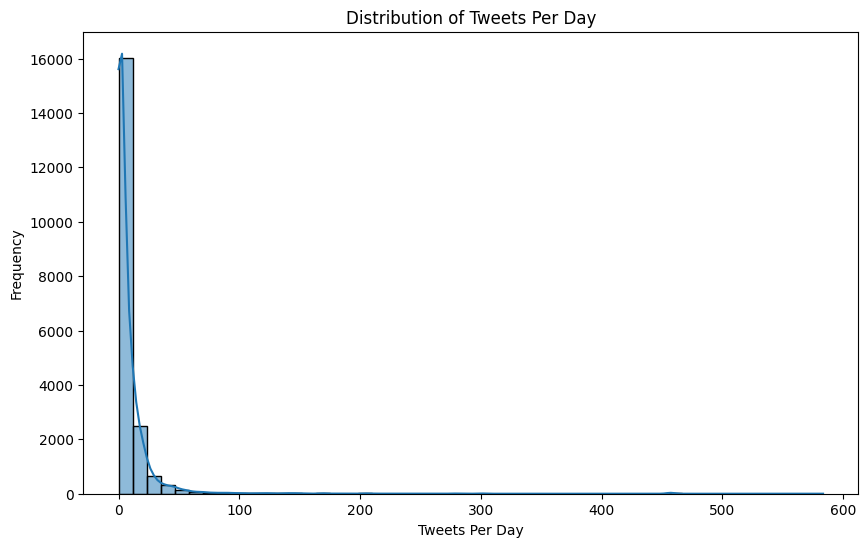

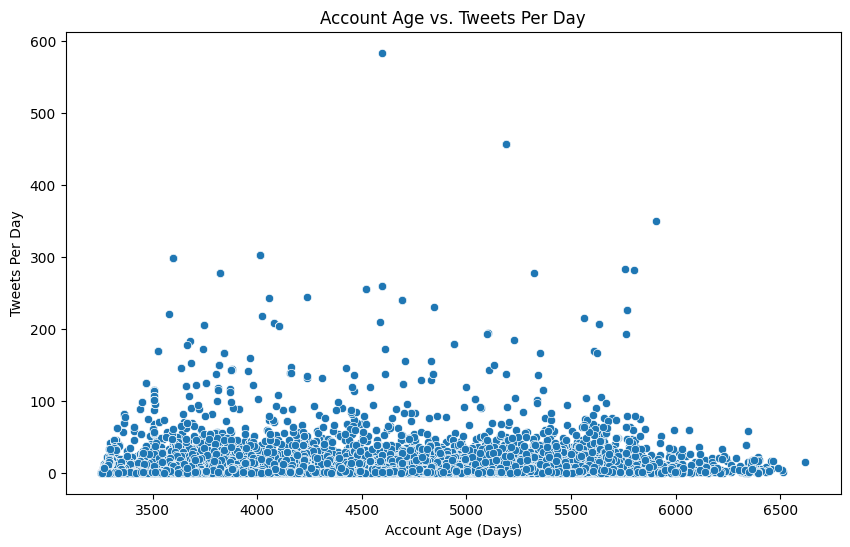


Number of NaN values in 'link_color': 0.
Number of NaN values in 'sidebar_color': 0.
Number of link color is 2986.
Number of side bar color is 559.
Number of NaN values in 'link_color': 0
Number of NaN values in 'sidebar_color': 0


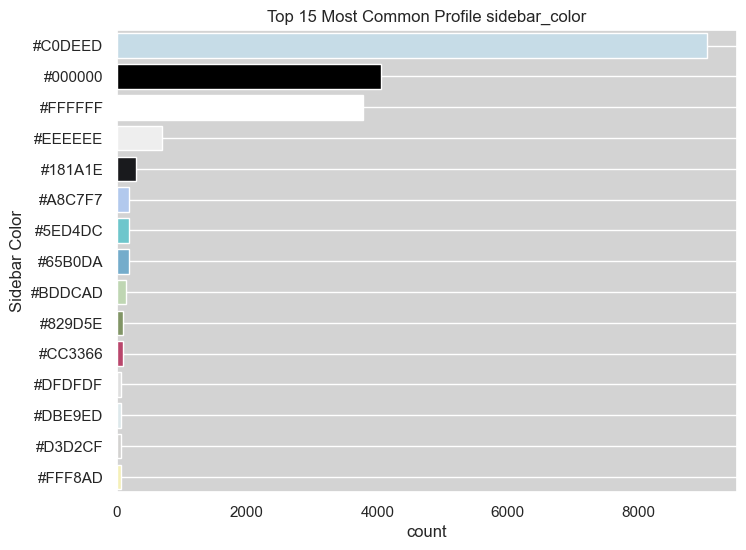

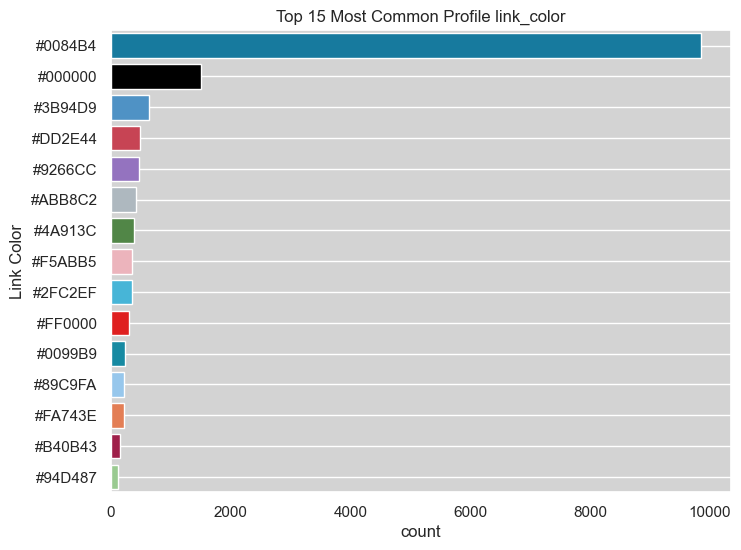

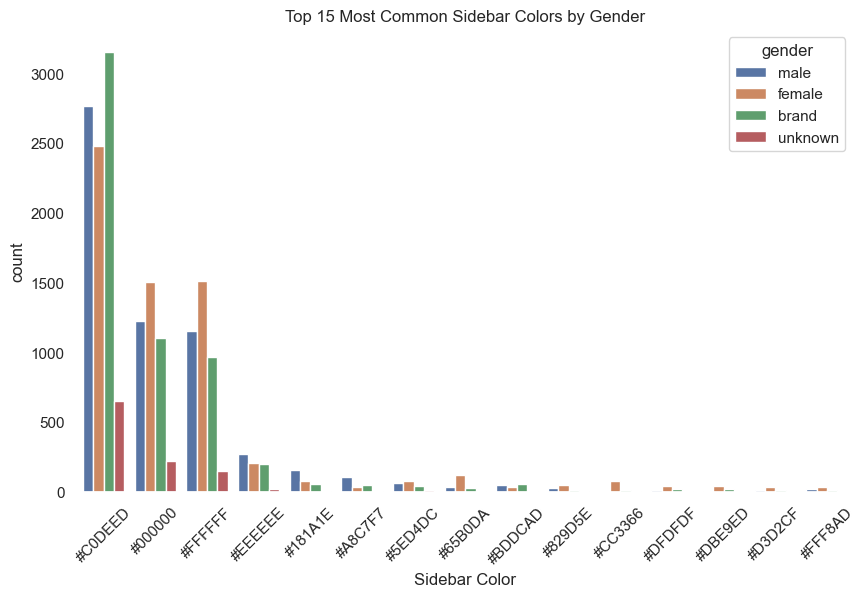

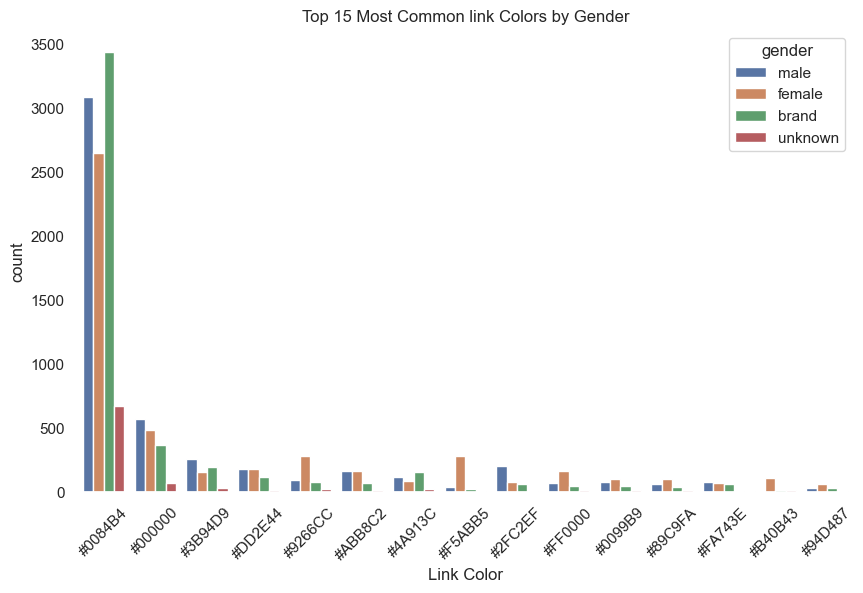

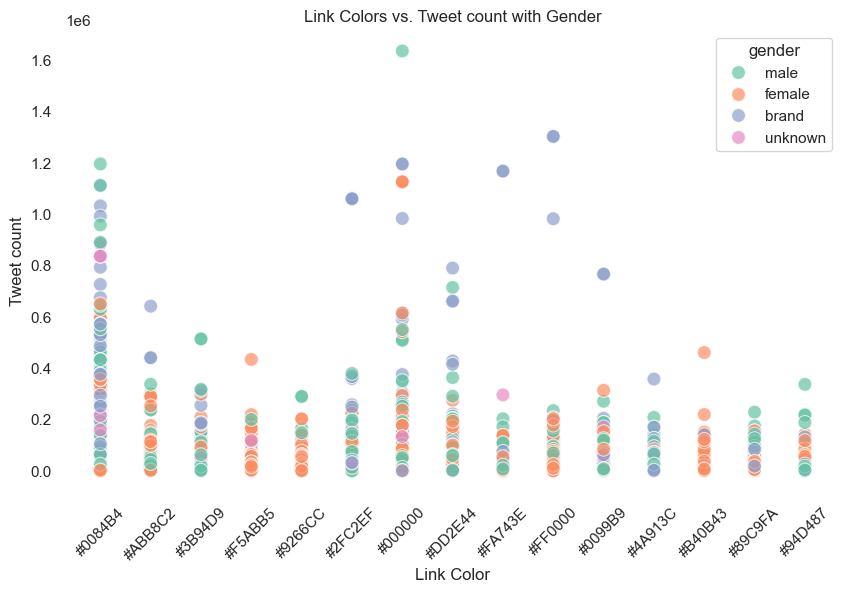

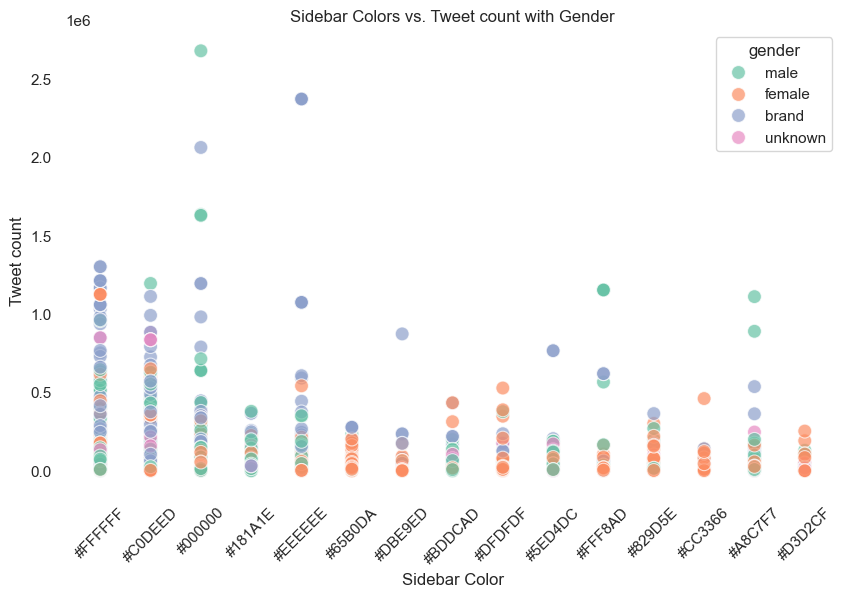

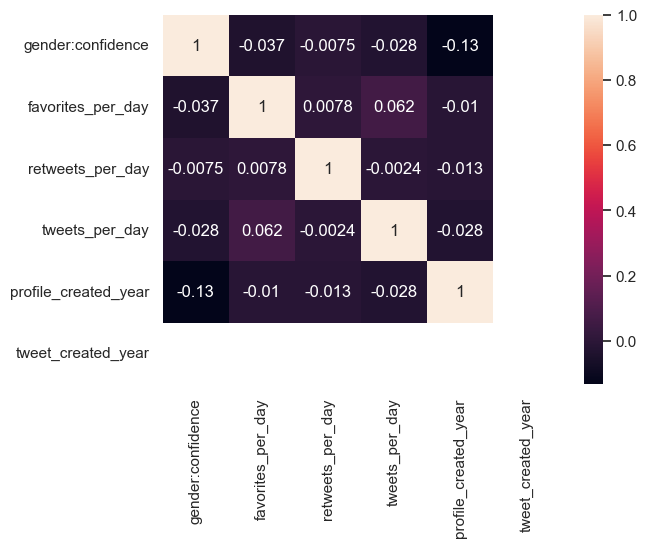


Unique Values in 'gender'
[0 1 2]
<class 'pandas.core.frame.DataFrame'>
Index: 18836 entries, 0 to 20049
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  18836 non-null  int64  
 1   gender:confidence       18836 non-null  float64
 2   description             15522 non-null  object 
 3   favorites_per_day       18836 non-null  float64
 4   link_color              18836 non-null  object 
 5   retweets_per_day        18836 non-null  float64
 6   sidebar_color           18836 non-null  object 
 7   text                    18836 non-null  object 
 8   tweets_per_day          18836 non-null  float64
 9   user_timezone           18836 non-null  object 
 10  tweet_location          18836 non-null  object 
 11  profile_created_year    18836 non-null  int32  
 12  tweet_created_year      18836 non-null  int32  
 13  tweet_location_encoded  18836 non-null  float64
 14  user_tim

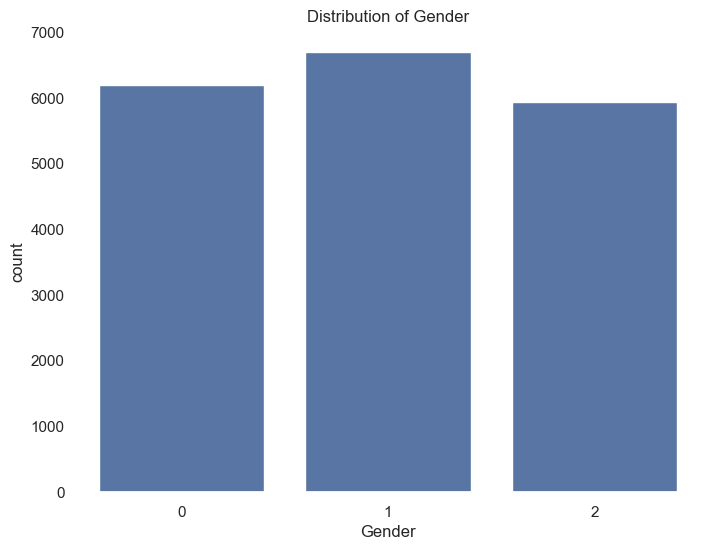


All Remaining Features
['gender', 'gender:confidence', 'description', 'favorites_per_day', 'retweets_per_day', 'text', 'tweets_per_day', 'profile_created_year', 'tweet_created_year', 'tweet_location_encoded', 'user_timezone_encoded']

Dataset Overview After PreProcessing
<class 'pandas.core.frame.DataFrame'>
Index: 18836 entries, 0 to 20049
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  18836 non-null  int64  
 1   gender:confidence       18836 non-null  float64
 2   description             15522 non-null  object 
 3   favorites_per_day       18836 non-null  float64
 4   retweets_per_day        18836 non-null  float64
 5   text                    18836 non-null  object 
 6   tweets_per_day          18836 non-null  float64
 7   profile_created_year    18836 non-null  int32  
 8   tweet_created_year      18836 non-null  int32  
 9   tweet_location_encoded  18836 non-n

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



                                             description  \
0                                  i sing my own rhythm.   
1      I'm the author of novels filled with family dr...   
2                    louis whining and squealing and all   
3      Mobile guy.  49ers, Shazam, Google, Kleiner Pe...   
4      Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   
...                                                  ...   
20045                                               (rp)   
20046  Whatever you like, it's not a problem at all. ...   
20047  #TeamBarcelona ..You look lost so you should f...   
20048  Anti-statist; I homeschool my kids. Aspiring t...   
20049                     Teamwork makes the dream work.   

                                                    text  
0      Robbie E Responds To Critics After Win Against...  
1      ÛÏIt felt like they were my friends and I was...  
2      i absolutely adore when louis starts the songs...  
3      Hi @JordanSpieth - Looking at the u

In [2]:
# Main starts here
# Load the dataset
df = pd.read_csv('twitter_user_data.csv', encoding='ISO-8859-1')

# Quick view of the dataset
print()
print('Dataset Overview')
print(df.info())
print(df.head())

all_features = df.columns

missing_col, df_cleaned = find_columns_with_missing(df, all_features)

# Dropping rows where 'gender' is missing
df_cleaned = df_cleaned.dropna(subset=['gender'])

# Drop the 'profile_yn' column since it is not relevant to human/non-human classification
df_cleaned = df_cleaned.drop(columns=['profile_yn'])

# Now that we have handled the missing data, you can proceed with further analysis
print()
print('Dataset Overview')
print(df_cleaned.info())
print(df_cleaned.head())

print()
print('---- EXPLORATORY DATA ANALYSIS (EDA) ----')

current_num_features = df.select_dtypes(include=[np.number])

# Plot distribution of each numerical feature with gender as hue using seaborn
for feature in current_num_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_cleaned, x=feature, hue='gender', bins=30, kde=True)
    plt.title(f'Distribution of {feature} by Gender')
    plt.show()

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df_cleaned)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

# Plot distribution of 'tweet_count' and 'retweet_count'
for column in ['tweet_count', 'retweet_count']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df_cleaned, x=column, kde=True, bins=30)
    plt.title(f'Distribution of {column.replace("_", " ").capitalize()}')
    plt.show()

# Correlation analysis for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[['tweet_count', 'retweet_count', 'fav_number']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Extracting date from 'created' and 'tweet_created' for time-based analysis
df_cleaned['profile_created_year'] = pd.to_datetime(df_cleaned['created']).dt.year
df_cleaned['tweet_created_year'] = pd.to_datetime(df_cleaned['tweet_created']).dt.year

# Ensure 'created' and tweet_created are in datetime format
df_cleaned['created'] = pd.to_datetime(df_cleaned['created'], errors='coerce')
df_cleaned['tweet_created'] = pd.to_datetime(df_cleaned['tweet_created'], errors='coerce')

# assuming Data was up-to-date
df_cleaned['account_age'] = (pd.Timestamp.now() - df_cleaned['created']).dt.days

df_cleaned['tweets_per_day'] = df_cleaned['tweet_count'] / df_cleaned['account_age']
df_cleaned['retweets_per_day'] = df_cleaned['retweet_count'] / df_cleaned['account_age']
df_cleaned['favorites_per_day'] = df_cleaned['fav_number'] / df_cleaned['account_age']

# Plotting the distribution of profile creation over the years
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['profile_created_year'], kde=False, bins=15)
plt.title('Distribution of Profile Creation Years')
plt.xlabel('Profile Created Year')
plt.ylabel('count')
plt.show()

# Plotting the histogram of tweets per day
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['tweets_per_day'], bins=50, kde=True)
plt.title('Distribution of Tweets Per Day')
plt.xlabel('Tweets Per Day')
plt.ylabel('Frequency')
plt.show()

# show the relationship between account age and tweets per day
plt.figure(figsize=(10, 6))
sns.scatterplot(x='account_age', y='tweets_per_day', data=df_cleaned)
plt.title('Account Age vs. Tweets Per Day')
plt.xlabel('Account Age (Days)')
plt.ylabel('Tweets Per Day')
plt.show()

# Exploring 'link_color' and 'sidebar_color' features

# Check number of NaN value in  'link_color' and 'sidebar_color' features
link_color_nan_count = df_cleaned['link_color'].isnull().sum()
sidebar_color_nan_count = df_cleaned['sidebar_color'].isnull().sum()

print()
print(f"Number of NaN values in 'link_color': {link_color_nan_count}.")
print(f"Number of NaN values in 'sidebar_color': {sidebar_color_nan_count}.")

# Check how many available colors in 'link_color' and 'sidebar_color' features
link_color_count = len(df_cleaned['link_color'].unique())
sidebar_color_count = len(df_cleaned['sidebar_color'].unique())
print(f'Number of link color is {link_color_count}.')
print(f'Number of side bar color is {sidebar_color_count}.')

# Apply the function to 'link_color' and 'sidebar_color'
df_cleaned['link_color'] = df_cleaned['link_color'].apply(lambda x: f'#{x}' if len(x) == 6 else '#000000')
df_cleaned['sidebar_color'] = df_cleaned['sidebar_color'].apply(lambda x: f'#{x}' if len(x) == 6 else '#000000')

# Drop rows where 'sidebar_color' is still NaN
df_cleaned = df_cleaned.dropna(subset=['link_color'])
df_cleaned = df_cleaned.dropna(subset=['sidebar_color'])
print(f"Number of NaN values in 'link_color': {df_cleaned['link_color'].isnull().sum()}")
print(f"Number of NaN values in 'sidebar_color': {df_cleaned['sidebar_color'].isnull().sum()}")

# top 15 colors
top_sidebar_colors = df_cleaned['sidebar_color'].value_counts().iloc[:15].index.tolist()
top_link_colors = df_cleaned['link_color'].value_counts().iloc[:15].index.tolist()
# print(top_sidebar_colors)

# Extract top 10 most common sidebar colors
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
sns.countplot(y='sidebar_color', data=df_cleaned, order=df_cleaned['sidebar_color'].value_counts().iloc[:15].index, palette=top_sidebar_colors)
plt.title('Top 15 Most Common Profile sidebar_color')
plt.ylabel('Sidebar Color')
plt.xlabel('count')
plt.grid()
plt.show()

# Extract top 10 most common link colors
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
plt.figure(figsize=(8, 6))
sns.countplot(y='link_color', data=df_cleaned, order=df_cleaned['link_color'].value_counts().iloc[:15].index, palette=top_link_colors)
plt.title('Top 15 Most Common Profile link_color')
plt.ylabel('Link Color')
plt.xlabel('count')
plt.grid()
plt.show()

# count plot for sidebar_color vs. gender
plt.figure(figsize=(10, 6))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.countplot(x='sidebar_color', hue='gender', data=df_cleaned,
              order=df_cleaned['sidebar_color'].value_counts().iloc[:15].index)
plt.title('Top 15 Most Common Sidebar Colors by Gender')
plt.xlabel('Sidebar Color')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

# count plot for link_color vs. gender
plt.figure(figsize=(10, 6))
sns.countplot(x='link_color', hue='gender', data=df_cleaned,
              order=df_cleaned['link_color'].value_counts().iloc[:15].index)
plt.title('Top 15 Most Common link Colors by Gender')
plt.xlabel('Link Color')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for link_color vs. tweet_count with gender as hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='link_color', y='tweet_count', hue='gender', data=df_cleaned[df_cleaned['link_color'].isin(top_link_colors)],
                palette='Set2', s=100, alpha=0.7)
plt.title('Link Colors vs. Tweet count with Gender')
plt.xlabel('Link Color')
plt.ylabel('Tweet count')
plt.xticks(rotation=45)
plt.show()

# Scatter plot for sidebar_color vs. tweet_count with gender as hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sidebar_color', y='tweet_count', hue='gender', data=df_cleaned[df_cleaned['sidebar_color'].isin(top_sidebar_colors)],
                palette='Set2', s=100, alpha=0.7)
plt.title('Sidebar Colors vs. Tweet count with Gender')
plt.xlabel('Sidebar Color')
plt.ylabel('Tweet count')
plt.xticks(rotation=45)
plt.show()

# Select columns to be used
col = ['gender', 'gender:confidence', 'description', 'favorites_per_day','link_color',
       'retweets_per_day', 'sidebar_color', 'text', 'tweets_per_day','user_timezone', 'tweet_location', 'profile_created_year', 'tweet_created_year'
       ]
df_preprocessed = df_cleaned[col].copy()
# Remove rows where gender is 'Unknown'
df_preprocessed = df_preprocessed[df_preprocessed['gender'] != 'unknown']

# Plot correlation matrix
corr_matrix = df_preprocessed.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Drop one feature from highly correlated pairs (correlation > 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_preprocessed = df_preprocessed.drop(columns=to_drop)

# Filling missing values for important features
df_preprocessed['user_timezone'].fillna('Unknown', inplace=True)
df_preprocessed['tweet_location'].fillna('Unknown', inplace=True)
categorical_features = ['user_timezone', 'tweet_location']

# categorise types of features

# numerical features
df_num = df_preprocessed[['retweets_per_day', 'favorites_per_day', 'tweets_per_day', 'profile_created_year', 'tweet_created_year']].copy()

# categorical features with frequency encoding
freq_encoding_location = df_preprocessed['tweet_location'].value_counts(normalize=True)
df_preprocessed['tweet_location_encoded'] = df_preprocessed['tweet_location'].map(freq_encoding_location)

freq_encoding_timezone = df_preprocessed['user_timezone'].value_counts(normalize=True)
df_preprocessed['user_timezone_encoded'] = df_preprocessed['user_timezone'].map(freq_encoding_timezone)

# gender features
# encode the 'gender' column to numeric values
df_preprocessed['gender'] = df_preprocessed['gender'].replace({'male': 0, 'female': 1, 'brand': 2})

# Check for unique values in the 'gender' column after replacement
print()
print("Unique Values in 'gender'")
print(df_preprocessed['gender'].unique())
print(df_preprocessed.info())

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df_preprocessed)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('count')
plt.show()

df_gender = df_preprocessed[['gender', 'gender:confidence']].copy()

# Drop the original categorical columns
df_preprocessed = df_preprocessed.drop(columns=categorical_features)

# Convert 'link_color' values
df_preprocessed['link_color_rgb'] = df_preprocessed['link_color'].apply(lambda x: hex_to_rgb(x) if isinstance(x, str) else (0,0,0))
# Convert 'sidebar_color' values
df_preprocessed['sidebar_color_rgb'] = df_preprocessed['sidebar_color'].apply(lambda x: hex_to_rgb(x) if isinstance(x, str) else (0,0,0))

rgb_df = pd.DataFrame(df_preprocessed['link_color_rgb'].to_list(), columns=['link_R', 'link_G', 'link_B'])
rgb_df = pd.concat([rgb_df, pd.DataFrame(df_preprocessed['sidebar_color_rgb'].to_list(), columns=['sidebar_R', 'sidebar_G', 'sidebar_B'])], axis=1)

# Drop the original color features
df_preprocessed = df_preprocessed.drop(columns=['link_color', 'sidebar_color', 'link_color_rgb', 'sidebar_color_rgb'])

# Check if all required features are there
print()
print('All Remaining Features')
print(df_preprocessed.columns.tolist())

# Define the numerical features to scale (filtering for int64 and float64 columns)
numerical_features = df_preprocessed.select_dtypes(include=[np.number])
# print(f'All current numerical features are {numerical_features.columns.tolist()}')

print()
print('Dataset Overview After PreProcessing')
print(df_preprocessed.info())

print()
print('---- NLP Processing ----')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

df_preprocessed['description'].fillna('', inplace=True)
df_preprocessed['text'].fillna('', inplace=True)
# df_preprocessed['name'].fillna('', inplace=True)

# Check the text features if they still contain NaN
print()
print(df_preprocessed.select_dtypes(include=[object]))

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply preprocessing to the 'description', 'text', and 'name' columns
df_preprocessed['cleaned_description'] = df_preprocessed['description'].apply(lambda x: preprocess_text(str(x)))
df_preprocessed['cleaned_text'] = df_preprocessed['text'].apply(lambda x: preprocess_text(str(x)))
# df_preprocessed['cleaned_name'] = df_preprocessed['name'].apply(lambda x: preprocess_text(str(x)))

# Check the preprocessed data with preprocessed text features
print(df_preprocessed[['description', 'cleaned_description', 'text', 'cleaned_text']].head())

# Drop the original text features
df_preprocessed = df_preprocessed.drop(columns=['description','text'])

# Initialize TFIDF vectorizer for text features
print()
print('Applying TF-IDF Vectorisation...')
tfidf_vectorizer = TfidfVectorizer(max_features=1500, stop_words='english')

# Apply TF-IDF on 'description', 'text', 'name' columns

tfidf_description = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_description']).toarray()
tfidf_text = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_text']).toarray()
# tfidf_name = tfidf_vectorizer.fit_transform(df_preprocessed['cleaned_name']).toarray()

# Convert TF-IDF into DataFrames and add to df_preprocessed
tfidf_desc_df = pd.DataFrame(tfidf_description, columns=[f'desc_{i}' for i in range(tfidf_description.shape[1])])
tfidf_text_df = pd.DataFrame(tfidf_text, columns=[f'text_{i}' for i in range(tfidf_text.shape[1])])
# tfidf_name_df = pd.DataFrame(tfidf_name, columns=[f'name_{i}' for i in range(tfidf_name.shape[1])])

# Merge with main dataframe
df_preprocessed = pd.concat([df_preprocessed.reset_index(drop=True), tfidf_desc_df, tfidf_text_df], axis=1)

# Drop the cleaned text features
df_preprocessed = df_preprocessed.drop(columns=['cleaned_description', 'cleaned_text'])

df_preprocessed = pd.concat([df_preprocessed, rgb_df], axis=1)

df_asso = df_preprocessed.copy()

df_cate = df_preprocessed[['tweet_location_encoded', 'user_timezone_encoded']].copy()

## CLUSTERING



---- CLUSTERING MODELS ----

EXP 1: USING ALL SELECTED FEATURES

Dataset for Exp 1
<class 'pandas.core.frame.DataFrame'>
Index: 17702 entries, 0 to 18835
Columns: 3013 entries, favorites_per_day to user_timezone_encoded
dtypes: float64(3013)
memory usage: 407.1 MB
None

Applying UMAP for dim reduction...


[I 2024-09-20 16:20:19,495] A new study created in memory with name: no-name-f656c2a4-43f7-454b-87f6-e1b8bbb5ba19


(17702, 2)

Performing K-Means Clustering...


[I 2024-09-20 16:20:24,756] Trial 0 finished with value: 0.44721555709838867 and parameters: {'n_clusters': 6, 'init': 'k-means++'}. Best is trial 0 with value: 0.44721555709838867.
[I 2024-09-20 16:20:29,547] Trial 1 finished with value: 0.40816256403923035 and parameters: {'n_clusters': 9, 'init': 'k-means++'}. Best is trial 0 with value: 0.44721555709838867.
[I 2024-09-20 16:20:34,470] Trial 2 finished with value: 0.43370768427848816 and parameters: {'n_clusters': 10, 'init': 'random'}. Best is trial 0 with value: 0.44721555709838867.
[I 2024-09-20 16:20:39,242] Trial 3 finished with value: 0.4106582999229431 and parameters: {'n_clusters': 7, 'init': 'random'}. Best is trial 0 with value: 0.44721555709838867.
[I 2024-09-20 16:20:44,060] Trial 4 finished with value: 0.3901534974575043 and parameters: {'n_clusters': 8, 'init': 'k-means++'}. Best is trial 0 with value: 0.44721555709838867.
[I 2024-09-20 16:20:48,864] Trial 5 finished with value: 0.4233592748641968 and parameters: {'n_c

Best params: {'n_clusters': 2, 'init': 'random'}


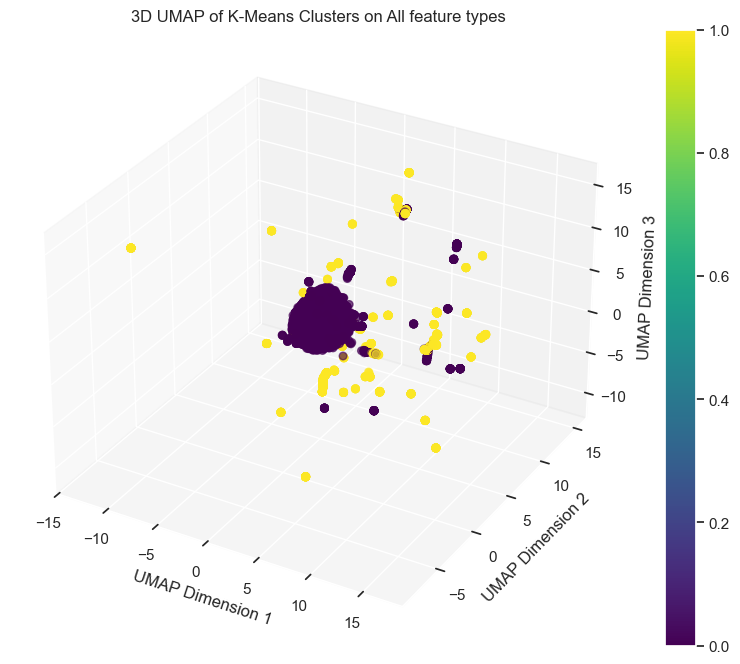

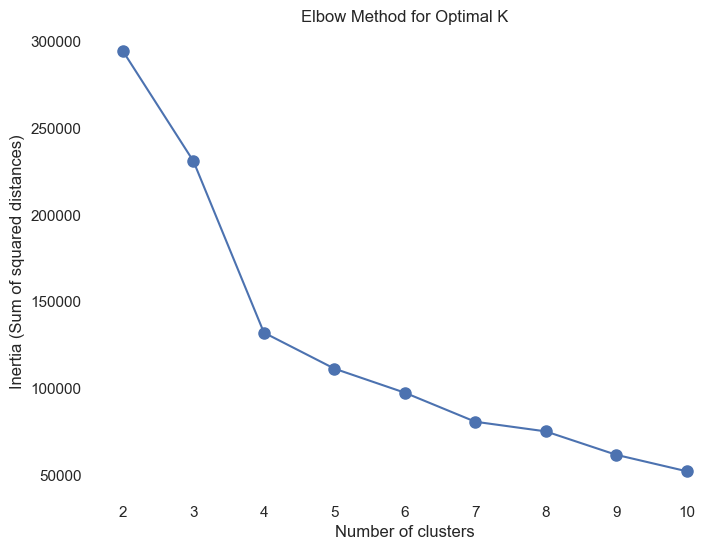

The Silhouette score is 0.7726734280586243
The Callinski index is 20992.505859375

Dataset with Labels from KMeans in Exp 1
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              0
1     0.0             1.0000              0
2     0.0             0.6625              0
3     0.0             1.0000              0
4     1.0             1.0000              0

Records found in cluster 0 from KMeans in Exp 1
       gender  gender:confidence  Cluster_Label
0         0.0             1.0000              0
1         0.0             1.0000              0
2         0.0             0.6625              0
3         0.0             1.0000              0
4         1.0             1.0000              0
...       ...                ...            ...
18829     1.0             1.0000              0
18831     0.0             0.6466              0
18832     1.0             1.0000              0
18834     1.0             1.0000              0
18835     0.0             0.6772   

[I 2024-09-20 16:21:42,026] A new study created in memory with name: no-name-ad1593d8-66bc-4c0f-9d74-f56f96710d50


       gender  gender:confidence  Cluster_Label
7         0.0             1.0000              1
33        0.0             1.0000              1
49        2.0             1.0000              1
56        1.0             0.6684              1
58        0.0             1.0000              1
...       ...                ...            ...
18738     2.0             1.0000              1
18753     0.0             0.6678              1
18759     0.0             0.6386              1
18789     0.0             1.0000              1
18803     1.0             1.0000              1

[1323 rows x 3 columns]
No. of records with gender 0 in cluster 1 is 404
No. of records with gender 1 in cluster 1 is 428
No. of records with gender 2 in cluster 1 is 491

Performing DBSCAN Clustering...


[I 2024-09-20 16:21:48,312] Trial 0 finished with value: 0.3155621588230133 and parameters: {'eps': 1.5913067486466435, 'min_samples': 6}. Best is trial 0 with value: 0.3155621588230133.
[I 2024-09-20 16:21:54,152] Trial 1 finished with value: 0.24721910059452057 and parameters: {'eps': 1.0376530894652887, 'min_samples': 18}. Best is trial 0 with value: 0.3155621588230133.
[I 2024-09-20 16:22:00,118] Trial 2 finished with value: 0.2345193773508072 and parameters: {'eps': 1.08924832783019, 'min_samples': 7}. Best is trial 0 with value: 0.3155621588230133.
[I 2024-09-20 16:22:06,672] Trial 3 finished with value: 0.3255881667137146 and parameters: {'eps': 1.9565357155432446, 'min_samples': 4}. Best is trial 3 with value: 0.3255881667137146.
[I 2024-09-20 16:22:13,131] Trial 4 finished with value: 0.32468611001968384 and parameters: {'eps': 1.9655521749248066, 'min_samples': 17}. Best is trial 3 with value: 0.3255881667137146.
[I 2024-09-20 16:22:19,013] Trial 5 finished with value: 0.2606

Found best params: {'eps': 1.6198251417047203, 'min_samples': 3}


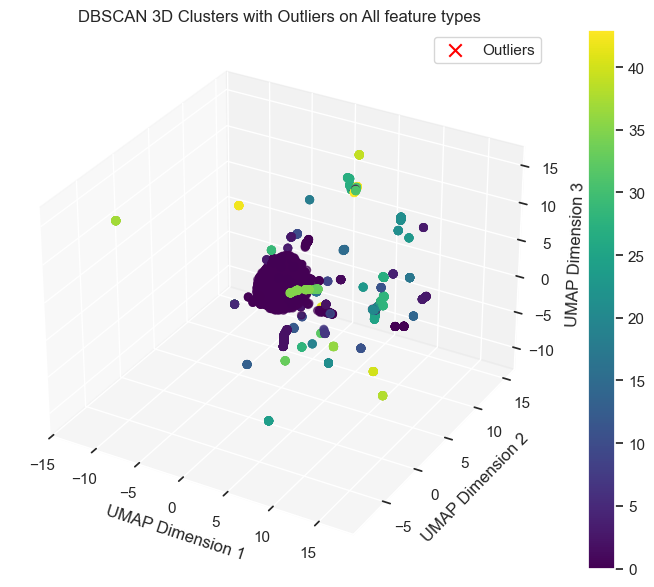

The Silhouette score is 0.33137843012809753
The Callinski index is 1748.1387939453125

Dataset with Labels from DBSCAN in Exp 1
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              0
1     0.0             1.0000              0
2     0.0             0.6625              0
3     0.0             1.0000              0
4     1.0             1.0000              0

Records found in cluster 0 from DBSCAN in Exp 1
       gender  gender:confidence  Cluster_Label
0         0.0             1.0000              0
1         0.0             1.0000              0
2         0.0             0.6625              0
3         0.0             1.0000              0
4         1.0             1.0000              0
...       ...                ...            ...
18829     1.0             1.0000              0
18831     0.0             0.6466              0
18832     1.0             1.0000              0
18834     1.0             1.0000              0
18835     0.0             0.677

[I 2024-09-20 16:23:48,010] A new study created in memory with name: no-name-f9550dca-d1e6-48ba-a676-9e841b5672d2


(17702, 3)

Performing K-Means Clustering...


[I 2024-09-20 16:23:51,598] Trial 0 finished with value: 0.3289636639097889 and parameters: {'n_clusters': 7, 'init': 'k-means++'}. Best is trial 0 with value: 0.3289636639097889.
[I 2024-09-20 16:23:55,202] Trial 1 finished with value: 0.37002461668723785 and parameters: {'n_clusters': 3, 'init': 'k-means++'}. Best is trial 1 with value: 0.37002461668723785.
[I 2024-09-20 16:23:58,694] Trial 2 finished with value: 0.34236426949671833 and parameters: {'n_clusters': 7, 'init': 'random'}. Best is trial 1 with value: 0.37002461668723785.
[I 2024-09-20 16:24:02,334] Trial 3 finished with value: 0.42740275911790543 and parameters: {'n_clusters': 5, 'init': 'k-means++'}. Best is trial 3 with value: 0.42740275911790543.
[I 2024-09-20 16:24:05,980] Trial 4 finished with value: 0.3327138746593811 and parameters: {'n_clusters': 2, 'init': 'k-means++'}. Best is trial 3 with value: 0.42740275911790543.
[I 2024-09-20 16:24:09,807] Trial 5 finished with value: 0.43672661408383706 and parameters: {'n

Best params: {'n_clusters': 2, 'init': 'random'}


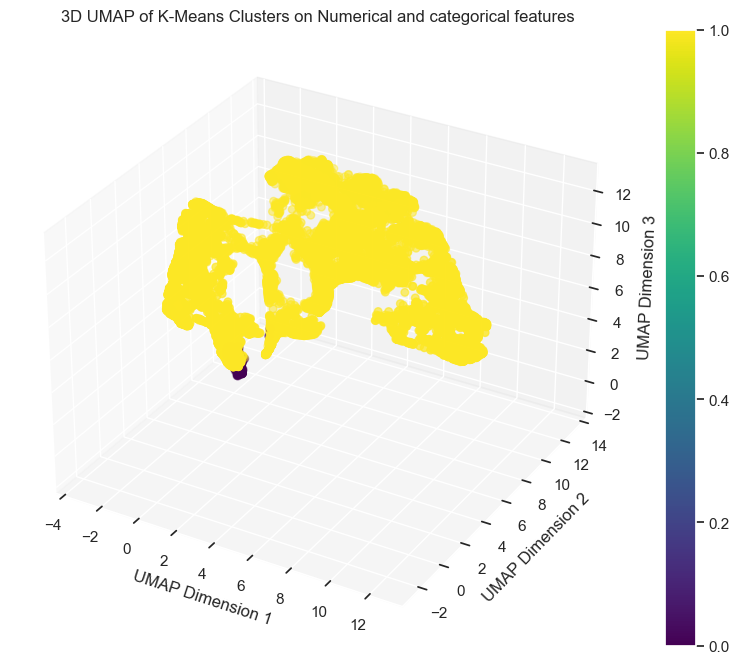

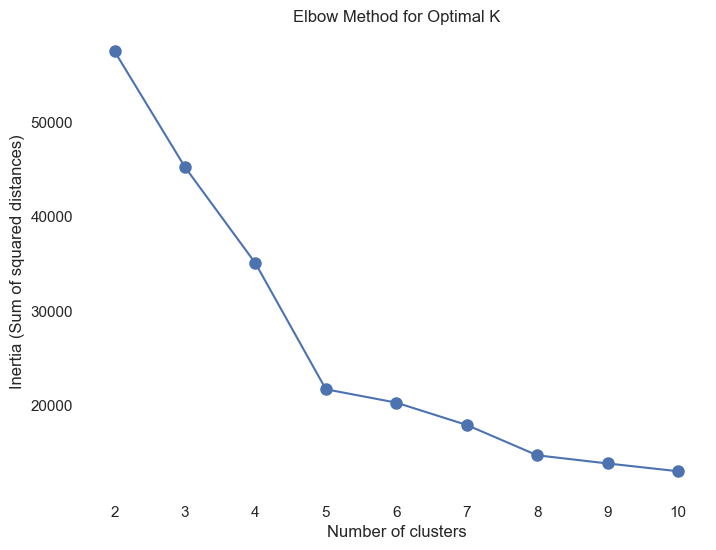

[I 2024-09-20 16:24:49,788] A new study created in memory with name: no-name-9347cc24-2c6f-4ad3-b792-5f023401ccdb


The Silhouette score is 0.7076370412066645
The Callinski index is 4482.755124226919

Dataset with Labels from KMeans in Exp 2
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              1
1     0.0             1.0000              1
2     0.0             0.6625              0
3     0.0             1.0000              1
4     1.0             1.0000              1

Records found in cluster 0 from KMeans in Exp 2
       gender  gender:confidence  Cluster_Label
2         0.0             0.6625              0
257       1.0             1.0000              0
286       2.0             1.0000              0
392       2.0             0.6576              0
429       1.0             1.0000              0
...       ...                ...            ...
18649     0.0             1.0000              0
18720     0.0             1.0000              0
18765     1.0             1.0000              0
18784     2.0             1.0000              0
18796     0.0             0.6760 

[I 2024-09-20 16:24:59,626] Trial 0 finished with value: 0.7395551461504506 and parameters: {'eps': 1.8612774559273246, 'min_samples': 17}. Best is trial 0 with value: 0.7395551461504506.
[I 2024-09-20 16:25:09,593] Trial 1 finished with value: 0.7395551461504506 and parameters: {'eps': 1.8222959595129316, 'min_samples': 16}. Best is trial 0 with value: 0.7395551461504506.
[I 2024-09-20 16:25:19,610] Trial 2 finished with value: 0.7286394402690954 and parameters: {'eps': 1.4969908447691442, 'min_samples': 15}. Best is trial 0 with value: 0.7395551461504506.
[I 2024-09-20 16:25:27,226] Trial 3 finished with value: 0.5245068941307643 and parameters: {'eps': 0.572252884608168, 'min_samples': 14}. Best is trial 0 with value: 0.7395551461504506.
[I 2024-09-20 16:25:37,404] Trial 4 finished with value: 0.7535863974003295 and parameters: {'eps': 1.9348801547784897, 'min_samples': 14}. Best is trial 4 with value: 0.7535863974003295.
[I 2024-09-20 16:25:47,748] Trial 5 finished with value: 0.73

Found best params: {'eps': 1.9873182476645224, 'min_samples': 12}


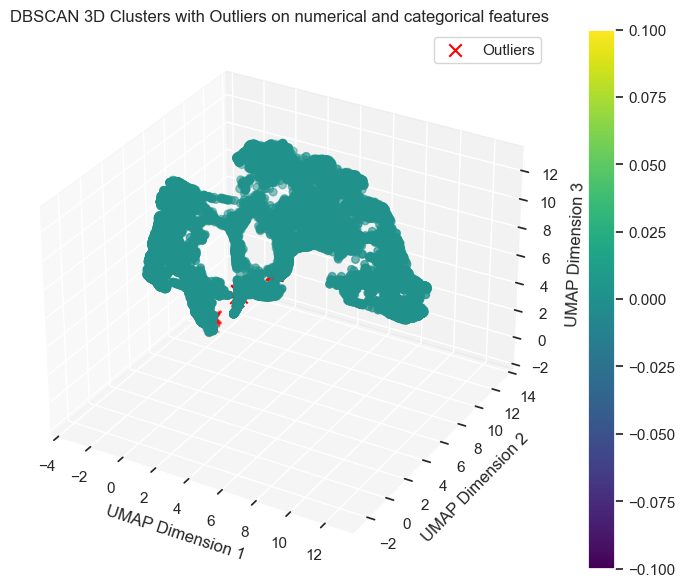

The Silhouette score is 0.7582461095915987
The Callinski index is 336.17121436944564

Dataset with Labels from DBSCAN in Exp 2
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              0
1     0.0             1.0000              0
2     0.0             0.6625              0
3     0.0             1.0000              0
4     1.0             1.0000              0

Records found in cluster 0 from DBSCAN in Exp 2
       gender  gender:confidence  Cluster_Label
0         0.0             1.0000              0
1         0.0             1.0000              0
2         0.0             0.6625              0
3         0.0             1.0000              0
4         1.0             1.0000              0
...       ...                ...            ...
18829     1.0             1.0000              0
18831     0.0             0.6466              0
18832     1.0             1.0000              0
18834     1.0             1.0000              0
18835     0.0             0.6772

[I 2024-09-20 16:30:24,130] A new study created in memory with name: no-name-36a03b0d-863a-4fa2-a02e-19e458c477ae



Performing K-Means Clustering...


[I 2024-09-20 16:30:29,152] Trial 0 finished with value: 0.3791390061378479 and parameters: {'n_clusters': 5, 'init': 'k-means++'}. Best is trial 0 with value: 0.3791390061378479.
[I 2024-09-20 16:30:34,447] Trial 1 finished with value: 0.7161176204681396 and parameters: {'n_clusters': 2, 'init': 'k-means++'}. Best is trial 1 with value: 0.7161176204681396.
[I 2024-09-20 16:30:39,434] Trial 2 finished with value: 0.37424296140670776 and parameters: {'n_clusters': 9, 'init': 'k-means++'}. Best is trial 1 with value: 0.7161176204681396.
[I 2024-09-20 16:30:44,536] Trial 3 finished with value: 0.3678858280181885 and parameters: {'n_clusters': 10, 'init': 'k-means++'}. Best is trial 1 with value: 0.7161176204681396.
[I 2024-09-20 16:30:49,831] Trial 4 finished with value: 0.718830943107605 and parameters: {'n_clusters': 4, 'init': 'random'}. Best is trial 4 with value: 0.718830943107605.
[I 2024-09-20 16:30:54,927] Trial 5 finished with value: 0.4103359282016754 and parameters: {'n_cluster

Best params: {'n_clusters': 4, 'init': 'random'}


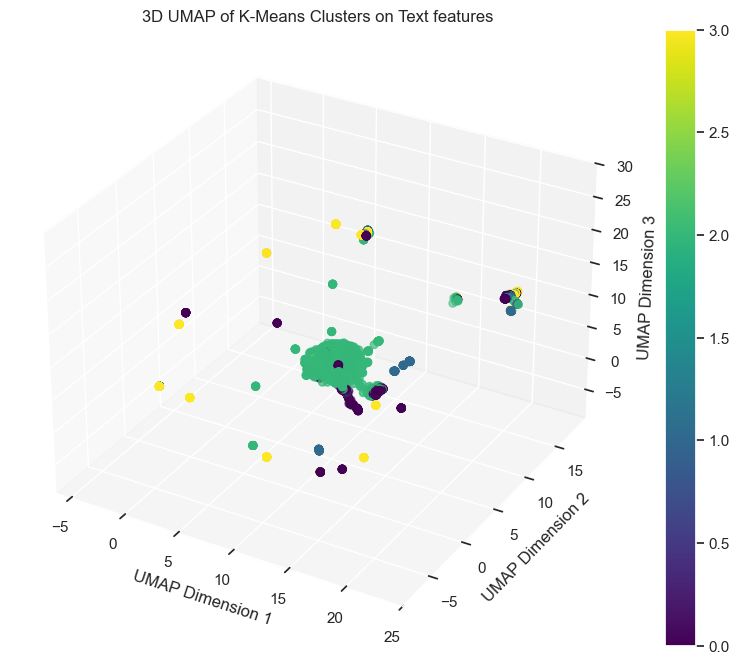

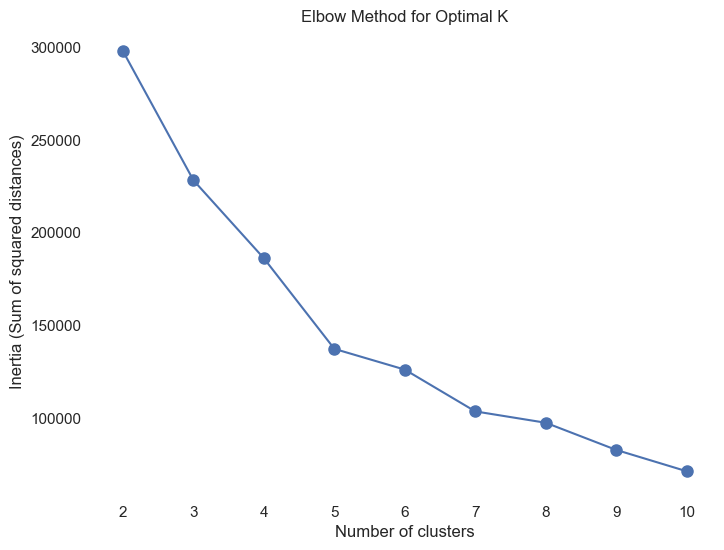

The Silhouette score is 0.718830943107605
The Callinski index is 10019.619140625

Dataset with Labels from KMeans in Exp 3
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              2
1     0.0             1.0000              2
2     0.0             0.6625              2
3     0.0             1.0000              2
4     1.0             1.0000              2

Records found in cluster 0 from KMeans in Exp 3
       gender  gender:confidence  Cluster_Label
42        2.0             1.0000              0
62        1.0             1.0000              0
166       0.0             1.0000              0
173       2.0             1.0000              0
190       2.0             0.6780              0
...       ...                ...            ...
18624     1.0             1.0000              0
18654     0.0             1.0000              0
18656     1.0             1.0000              0
18673     0.0             1.0000              0
18722     1.0             0.3371    

[I 2024-09-20 16:31:50,732] A new study created in memory with name: no-name-3c57886b-d112-4b57-9312-be650d49f11f


       gender  gender:confidence  Cluster_Label
261       1.0                1.0              3
336       0.0                1.0              3
575       0.0                1.0              3
929       1.0                1.0              3
1172      0.0                1.0              3
...       ...                ...            ...
18510     1.0                1.0              3
18609     1.0                1.0              3
18731     1.0                1.0              3
18738     2.0                1.0              3
18764     1.0                1.0              3

[558 rows x 3 columns]
No. of records with gender 0 in cluster 3 is 154
No. of records with gender 1 in cluster 3 is 176
No. of records with gender 2 in cluster 3 is 228

Performing DBSCAN Clustering...


[I 2024-09-20 16:31:56,283] Trial 0 finished with value: 0.07267794013023376 and parameters: {'eps': 0.224350065881816, 'min_samples': 12}. Best is trial 0 with value: 0.07267794013023376.
[I 2024-09-20 16:32:03,308] Trial 1 finished with value: 0.5760640501976013 and parameters: {'eps': 1.981346472478528, 'min_samples': 13}. Best is trial 1 with value: 0.5760640501976013.
[I 2024-09-20 16:32:09,091] Trial 2 finished with value: 0.456826776266098 and parameters: {'eps': 0.5994244424252012, 'min_samples': 10}. Best is trial 1 with value: 0.5760640501976013.
[I 2024-09-20 16:32:15,888] Trial 3 finished with value: 0.5654299259185791 and parameters: {'eps': 1.6306995770185833, 'min_samples': 12}. Best is trial 1 with value: 0.5760640501976013.
[I 2024-09-20 16:32:21,989] Trial 4 finished with value: 0.40619421005249023 and parameters: {'eps': 0.9888580285943404, 'min_samples': 7}. Best is trial 1 with value: 0.5760640501976013.
[I 2024-09-20 16:32:27,401] Trial 5 finished with value: 0.06

Found best params: {'eps': 1.981346472478528, 'min_samples': 13}


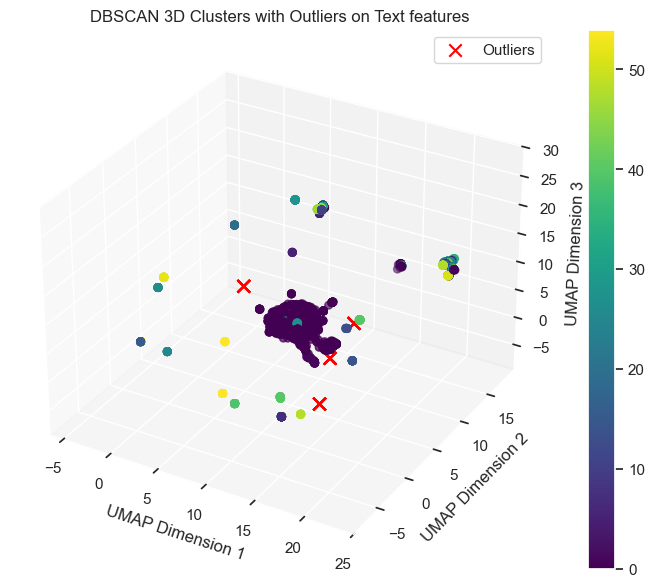

The Silhouette score is 0.5760640501976013
The Callinski index is 1357.848876953125

Dataset with Labels from DBSCAN in Exp 3
   gender  gender:confidence  Cluster_Label
0     0.0             1.0000              0
1     0.0             1.0000              0
2     0.0             0.6625              0
3     0.0             1.0000              0
4     1.0             1.0000              0

Records found in cluster 0 from DBSCAN in Exp 3
       gender  gender:confidence  Cluster_Label
0         0.0             1.0000              0
1         0.0             1.0000              0
2         0.0             0.6625              0
3         0.0             1.0000              0
4         1.0             1.0000              0
...       ...                ...            ...
18829     1.0             1.0000              0
18831     0.0             0.6466              0
18832     1.0             1.0000              0
18834     1.0             1.0000              0
18835     0.0             0.6772 

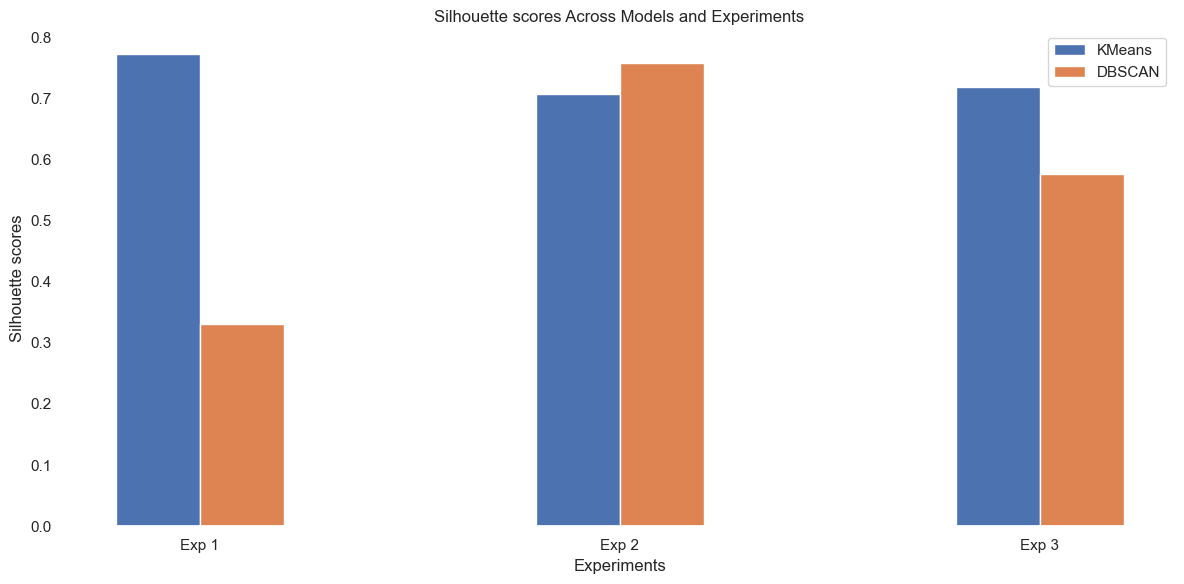

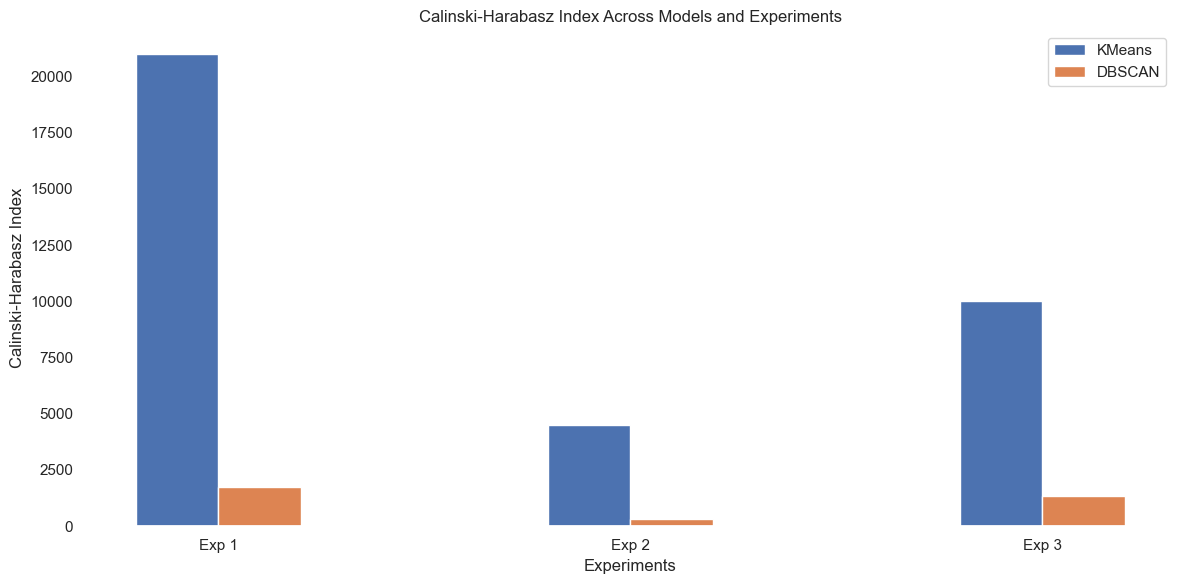

In [3]:
print()
print()
print('---- CLUSTERING MODELS ----')

print()
print("=" * 50)
print('EXP 1: USING ALL SELECTED FEATURES')
print("=" * 50)

sil_ex1 = []
cal_ex1 = []
# Drop the gender and categorical features before normalise

df_cat = df_cate.copy()
# Drop gender feature and categorical features
df_preprocessed = df_preprocessed.drop(columns=df_cat.columns)
df_finalised = df_preprocessed.drop(columns=['gender', 'gender:confidence'])

# Normalise every existing feature
scaler = StandardScaler()
df_finalised = pd.DataFrame(scaler.fit_transform(df_finalised), columns=df_finalised.columns)

df_finalised = pd.concat([df_finalised, df_cat, df_gender], axis=1)
# find the rows that contained NaN values and drop them
df_finalised = df_finalised.dropna()

data_exp1 = df_finalised
df_ex1 = df_finalised.drop(columns=['gender', 'gender:confidence'])


# Check the preprocessed dataset in the present
print()
print('Dataset for Exp 1')
print(df_ex1.info())
print()

# Apply UMAP for dimensionality reduction
print('Applying UMAP for dim reduction...')
umap_model = umap.UMAP()
umap_vis = umap.UMAP(n_neighbors=30,min_dist=0.1, n_components=3, random_state=42)
umap_embedding = umap_model.fit_transform(df_ex1)
umap_plot = umap_vis.fit_transform(df_ex1)
print(umap_embedding.shape)

# K-Means Clustering
print()
print('Performing K-Means Clustering...')
kmeans_clustering = KMeansClustering(umap_embedding)
kmeans_clustering.tune_hyperparameters()
kmeans_exp1 = kmeans_clustering.fit_model()
kmeans_clustering.visualize_clusters(umap_plot, 'All feature types')
kmeans_clustering.plot_elbow_method()
k_labels = kmeans_clustering.output_label()
sil_ex1.append(kmeans_clustering.silhoutte())
cal_ex1.append(kmeans_clustering.calinski())

k_retriever = ClusteringDataRetriever(data_exp1, k_labels)
df_with_labels = k_retriever.get_data_with_labels()

print()
print('Dataset with Labels from KMeans in Exp 1')
print(df_with_labels.head())
for label in np.unique(k_labels):
    print()
    print(f'Records found in cluster {label} from KMeans in Exp 1')
    print(k_retriever.get_cluster_data(label))
    print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')

# DBSCAN Clustering
print()
print('Performing DBSCAN Clustering...')
dbscan_clustering = DBSCANClustering(umap_embedding)
dbscan_clustering.tune_hyperparameters()
dbscan_exp1 = dbscan_clustering.fit_model()
dbscan_clustering.visualize_clusters_and_outliers_3D(umap_plot, 'All feature types')
db_labels = dbscan_clustering.output_label()
sil_ex1.append(dbscan_clustering.silhoutte())
cal_ex1.append(dbscan_clustering.calinski())

# Initialize the class to retrieve data
db_retriever = ClusteringDataRetriever(data_exp1, db_labels)
df_with_labels = db_retriever.get_data_with_labels()
print()
print('Dataset with Labels from DBSCAN in Exp 1')
print(df_with_labels.head())
for label in np.unique(db_labels):
    if label != -1:
        print()
        print(f'Records found in cluster {label} from DBSCAN in Exp 1')
        print(db_retriever.get_cluster_data(label))
        print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
print('Records classified as noise')
print(db_retriever.get_noise_data())

print()
print("=" * 50)
print('EXP 2: USING ONLY NUMERICAL AND CATEGORICAL FEATURES')
print("=" * 50)

sil_ex2 = []
cal_ex2 = []

# Normalise every existing feature
scaler = StandardScaler()
chunk_size = 100
for i in range(0, df_num.shape[0], chunk_size):
    df_num.iloc[i:i + chunk_size] = scaler.fit_transform(df_num.iloc[i:i + chunk_size])
df_no_text = pd.concat([df_num, df_cate, df_gender], axis=1)
print()
print("Data with Only Numerical and Categorical Features")
print(df_no_text.info())
print()

df_no_text = df_no_text.dropna()
df_no_text_wg = df_no_text.copy()
print('Removing NaN values...')

# Drop gender feature before clustering
data_exp2 = df_no_text.drop(columns=['gender', 'gender:confidence'])
print('Dropping gender and gender:confidence...')

# Check No. of records after drop NaN values
print()
print("Dataset for Exp 2")
print(data_exp2.info())
print()
print(data_exp2.head())

# Apply UMAP for dimensionality reduction
print('Applying UMAP for dim reduction...')
umap_model = umap.UMAP(n_neighbors=30,min_dist=0.1, n_components=3, random_state=42)
umap_embedding = umap_model.fit_transform(data_exp2)
print(umap_embedding.shape)
# umap_embedding = umap_embedding.astype(np.float32)

# K-Means Clustering
print()
print('Performing K-Means Clustering...')
kmeans_clustering = KMeansClustering(data_exp2)
kmeans_clustering.tune_hyperparameters()
kmeans_exp2 = kmeans_clustering.fit_model()
kmeans_clustering.visualize_clusters(umap_embedding, 'Numerical and categorical features')  # Visualize clusters
kmeans_clustering.plot_elbow_method()
k_labels = kmeans_clustering.output_label()
sil_ex2.append(kmeans_clustering.silhoutte())
cal_ex2.append(kmeans_clustering.calinski())

k_retriever = ClusteringDataRetriever(df_no_text_wg, k_labels)
df_with_labels = k_retriever.get_data_with_labels()
print()
print('Dataset with Labels from KMeans in Exp 2')
print(df_with_labels.head())
for label in np.unique(k_labels):
    print()
    print(f'Records found in cluster {label} from KMeans in Exp 2')
    print(k_retriever.get_cluster_data(label))
    print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')

# DBSCAN Clustering
print()
print('Performing DBSCAN Clustering...')
dbscan_clustering = DBSCANClustering(data_exp2)
dbscan_clustering.tune_hyperparameters()  # Tune DBSCAN hyperparameters
dbscan_exp2 = dbscan_clustering.fit_model()  # Fit the DBSCAN model
dbscan_clustering.visualize_clusters_and_outliers_3D(umap_embedding, 'numerical and categorical features')  # Plot 3D noise points and valid clusters
db_labels = dbscan_clustering.output_label()
sil_ex2.append(dbscan_clustering.silhoutte())
cal_ex2.append(dbscan_clustering.calinski())


db_retriever = ClusteringDataRetriever(df_no_text_wg, db_labels)
df_with_labels = db_retriever.get_data_with_labels()
print()
print('Dataset with Labels from DBSCAN in Exp 2')
print(df_with_labels.head())
for label in np.unique(db_labels):
    if label != -1:
        print()
        print(f'Records found in cluster {label} from DBSCAN in Exp 2')
        print(db_retriever.get_cluster_data(label))
        print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
print('Records classified as noise')
print(db_retriever.get_noise_data())

print()
print("=" * 50)
print('EXP 3: USING ONLY TEXT FEATURES')
print("=" * 50)

sil_ex3 = []
cal_ex3 = []
# Merge with main dataframe
df_with_text = pd.concat([tfidf_desc_df, tfidf_text_df], axis=1)
# Normalise every existing feature
scaler = StandardScaler()
chunk_size = 100
for i in range(0, df_with_text.shape[0], chunk_size):
    df_with_text.iloc[i:i + chunk_size] = scaler.fit_transform(df_with_text.iloc[i:i + chunk_size])

df_with_text_wg = pd.concat([df_with_text, df_gender], axis=1)
# Drop NaN values before clustering
df_with_text_wg = df_with_text_wg.dropna()
data_exp3 = df_with_text_wg.drop(columns=['gender', 'gender:confidence'])

# Drop the gender features before clustering

print('Dataset for Exp 3')
print(data_exp3.info())
print()
print(data_exp3.head())

print('Applying UMAP for dim reduction...')
umap_model = umap.UMAP()
umap_embedding_t = umap_model.fit_transform(data_exp3)
umap_embedding = umap.UMAP(n_neighbors=30,min_dist=0.1, n_components=3, random_state=42).fit_transform(data_exp3)

# K-Means Clustering
print()
print('Performing K-Means Clustering...')
kmeans_clustering = KMeansClustering(umap_embedding_t)
kmeans_clustering.tune_hyperparameters()
kmeans_exp3 = kmeans_clustering.fit_model()
kmeans_clustering.visualize_clusters(umap_embedding, 'Text features')
kmeans_clustering.plot_elbow_method()
k_labels = kmeans_clustering.output_label()
sil_ex3.append(kmeans_clustering.silhoutte())
cal_ex3.append(kmeans_clustering.calinski())

k_retriever = ClusteringDataRetriever(df_with_text_wg, k_labels)
df_with_labels = k_retriever.get_data_with_labels()
print()
print('Dataset with Labels from KMeans in Exp 3')
print(df_with_labels.head())
for label in np.unique(k_labels):
    print()
    print(f'Records found in cluster {label} from KMeans in Exp 3')
    print(k_retriever.get_cluster_data(label))
    print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
    print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')

# DBSCANClustering
print()
print('Performing DBSCAN Clustering...')
dbscan_clustering = DBSCANClustering(umap_embedding_t)
dbscan_clustering.tune_hyperparameters()
dbscan_exp3 = dbscan_clustering.fit_model()
dbscan_clustering.visualize_clusters_and_outliers_3D(umap_embedding, 'Text features')
db_labels = dbscan_clustering.output_label()
sil_ex3.append(dbscan_clustering.silhoutte())
cal_ex3.append(dbscan_clustering.calinski())

db_retriever = ClusteringDataRetriever(df_with_text_wg, db_labels)
df_with_labels = db_retriever.get_data_with_labels()
print()
print('Dataset with Labels from DBSCAN in Exp 3')
print(df_with_labels.head())
for label in np.unique(db_labels):
    if label != -1:
        print()
        print(f'Records found in cluster {label} from DBSCAN in Exp 3')
        print(db_retriever.get_cluster_data(label))
        print(f'No. of records with gender 0 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 0) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 1 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 1) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
        print(f'No. of records with gender 2 in cluster {label} is {df_with_labels[(df_with_labels["gender"] == 2) & (df_with_labels["Cluster_Label"] == label)].shape[0]}')
print('Records classified as noise')
print(db_retriever.get_noise_data())

print()
print('---- VISUALIZE THE METRIC EVALUATION ----')

# Metric functions
model_names = ['KMeans', 'DBSCAN']

sil_scores = [sil_ex1, sil_ex2, sil_ex3]
cal_scores = [cal_ex1, cal_ex2, cal_ex3]

plot_silhouette_bar_across_experiments(model_names, sil_scores)
visualize_ch_index_across_experiments(model_names, cal_scores)

## REGRESSION




Boosted Regression Tree with Vectorised Text/Desc Features
Mean Squared Error (Train): 0.0266
Mean Squared Error (Test): 0.0290
Mean Squared Error (Total): 0.0280


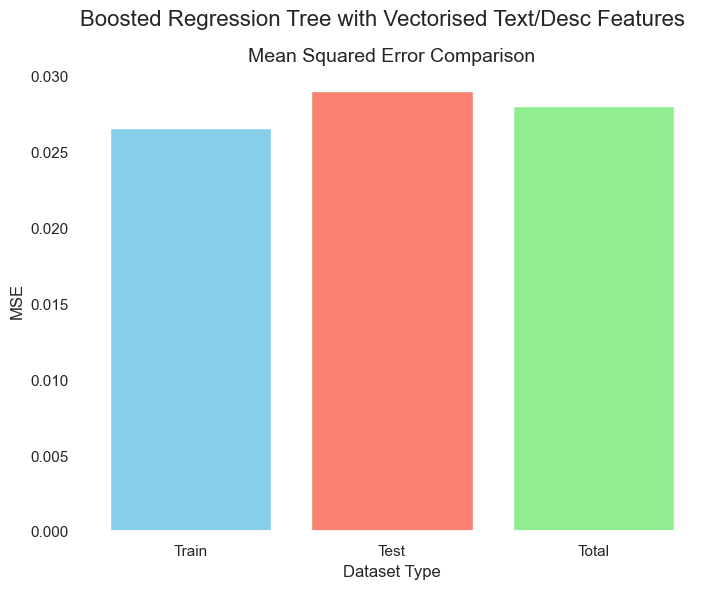


Performing feature importance analysis...
       desc      text  favorites_per_day  retweets_per_day  tweets_per_day  \
0  0.308771  0.364314           0.021232               0.0        0.121167   

   profile_created_year  tweet_created_year    link_R    link_G    link_B  \
0              0.155415                 0.0  0.000336  0.011339  0.000434   

   sidebar_R  sidebar_G  sidebar_B  
0   0.005375   0.006886    0.00473  


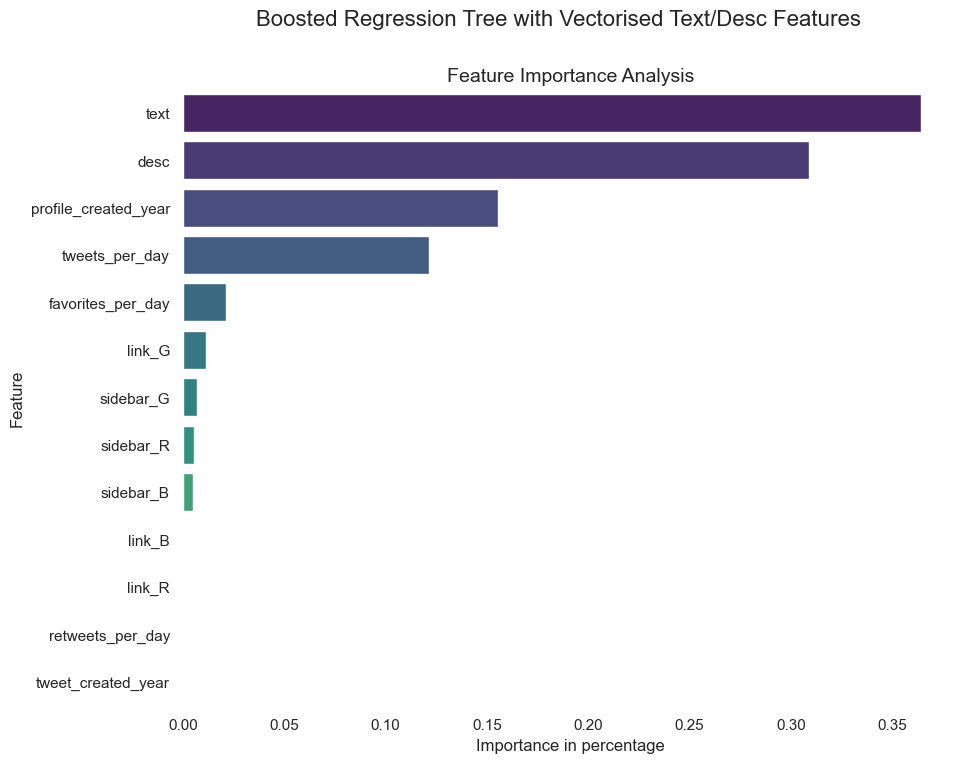

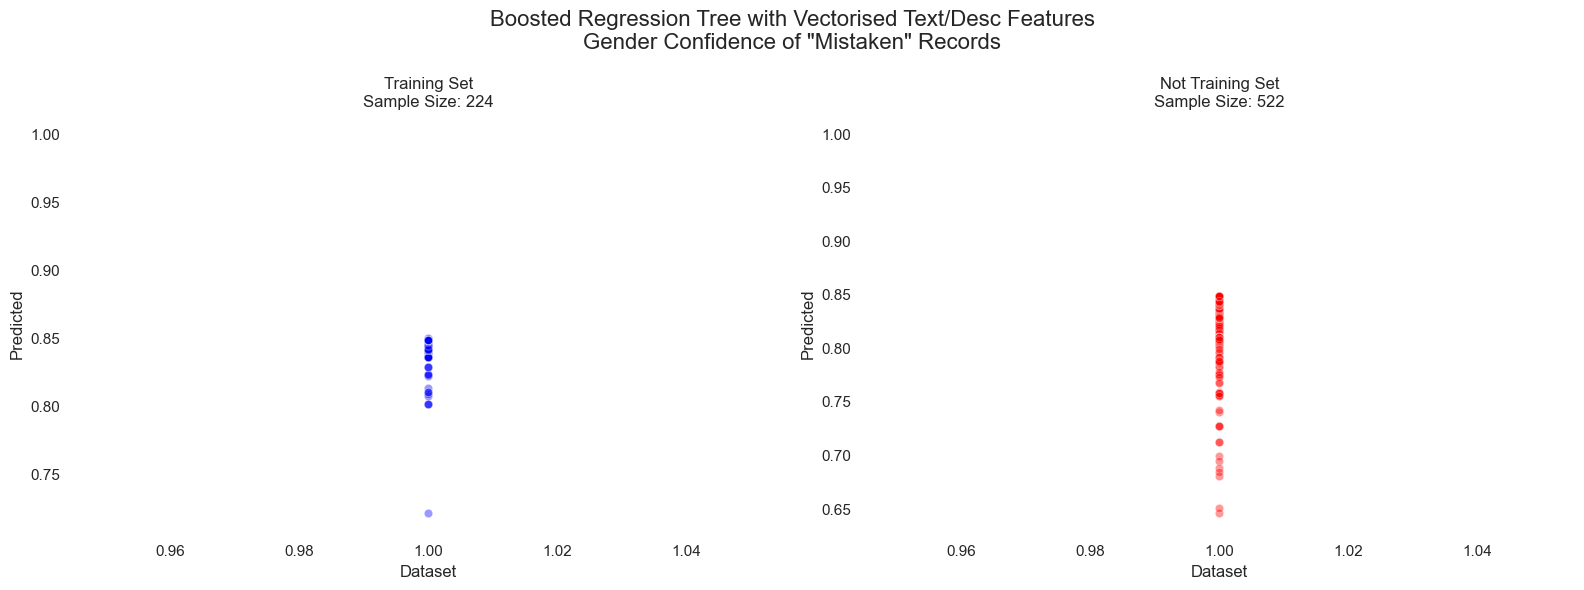

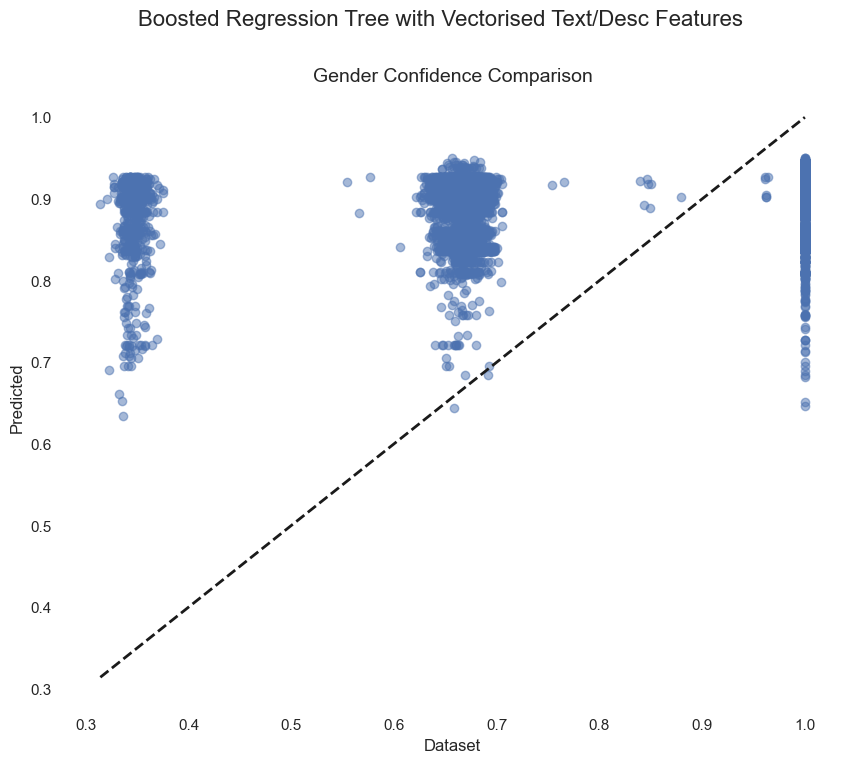

       favorites_per_day  retweets_per_day  tweets_per_day  \
0               0.000000          0.000000       28.149163   
1               0.015554          0.000000        1.708829   
2               2.147321          0.000279        1.567243   
3               0.036207          0.000000        0.303459   
4               9.794751          0.000000        8.257743   
...                  ...               ...             ...   
18831           0.090609          0.000000        0.234923   
18832           0.568809          0.000000        3.060887   
18833           0.011364          0.000000        6.004318   
18834          16.333103          0.000000       12.934948   
18835           0.878510          0.000000        0.766728   

       profile_created_year  tweet_created_year  link_R  link_G  link_B  \
0                      2013                2015       8     194     194   
1                      2012                2015       0     132     180   
2                      2014   

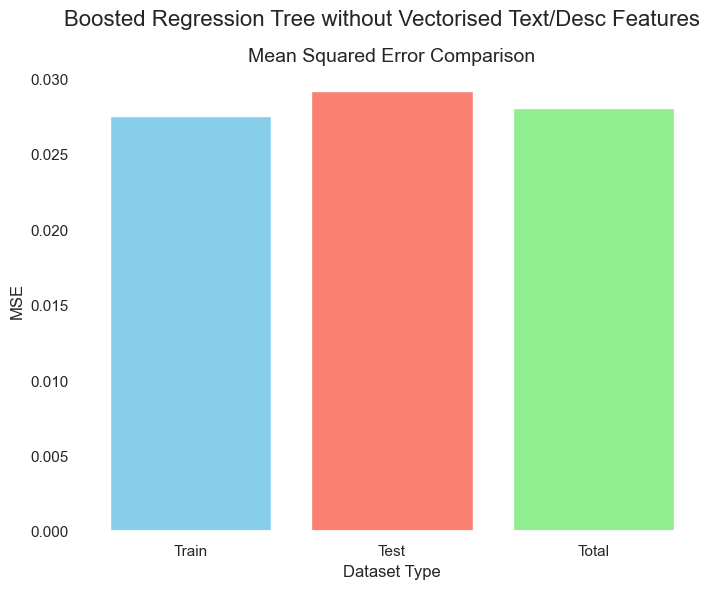


Performing feature importance analysis...


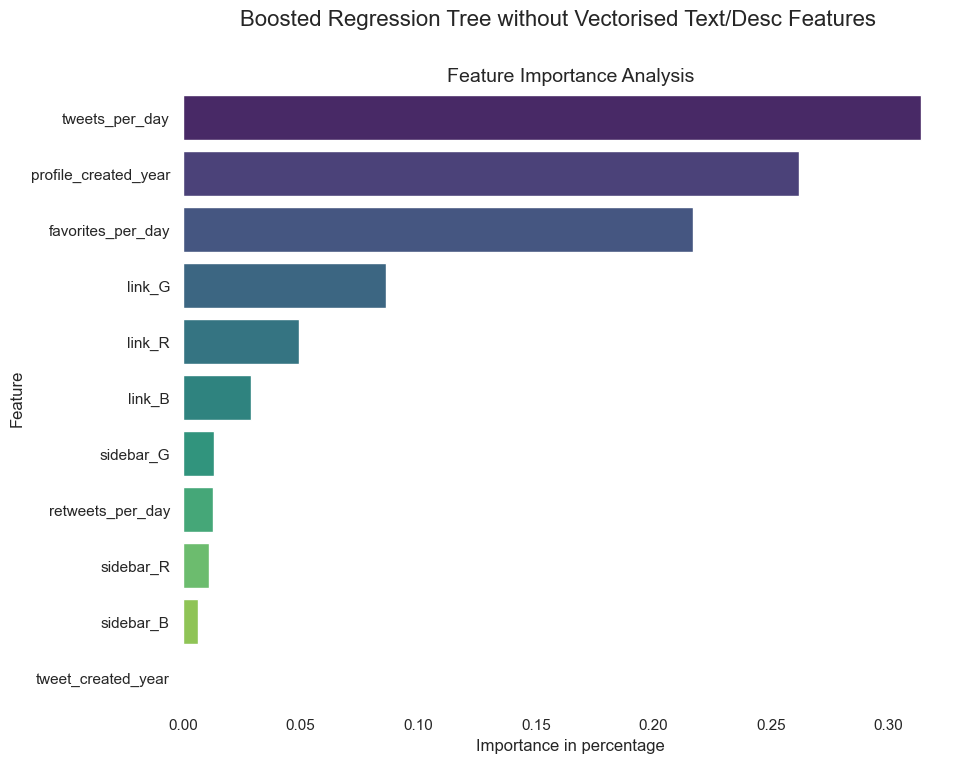

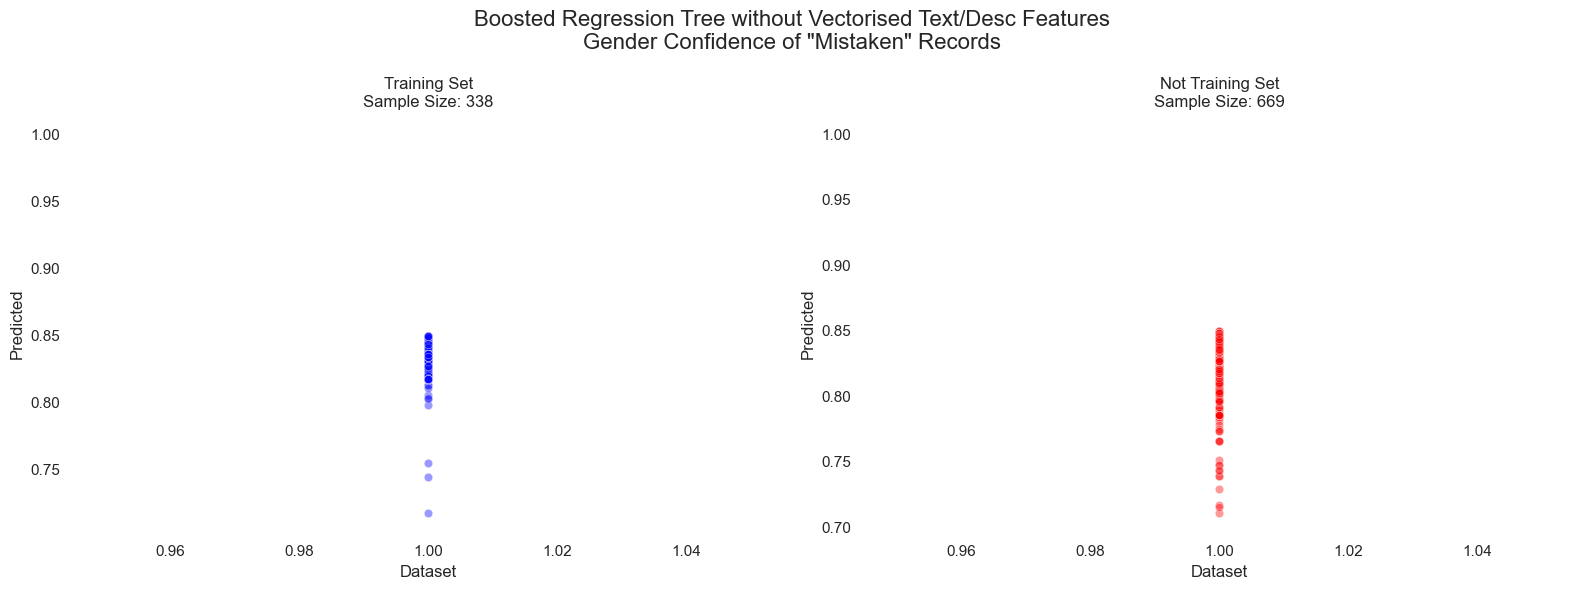

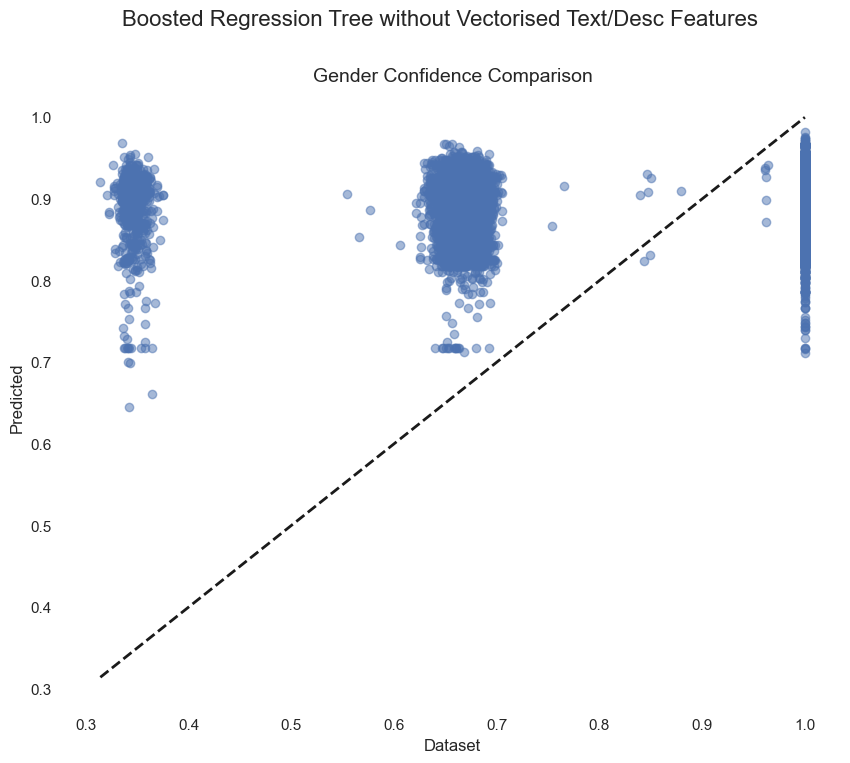


Linear Regression Tree with Vectorised Text/Desc Features
Mean Squared Error (Train): 0.0166
Mean Squared Error (Test): 0.0499
Mean Squared Error (Total): 0.0366


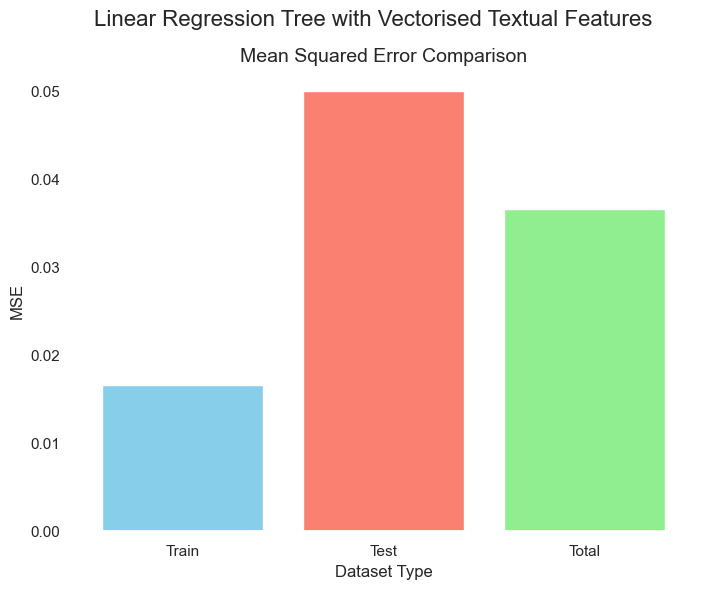

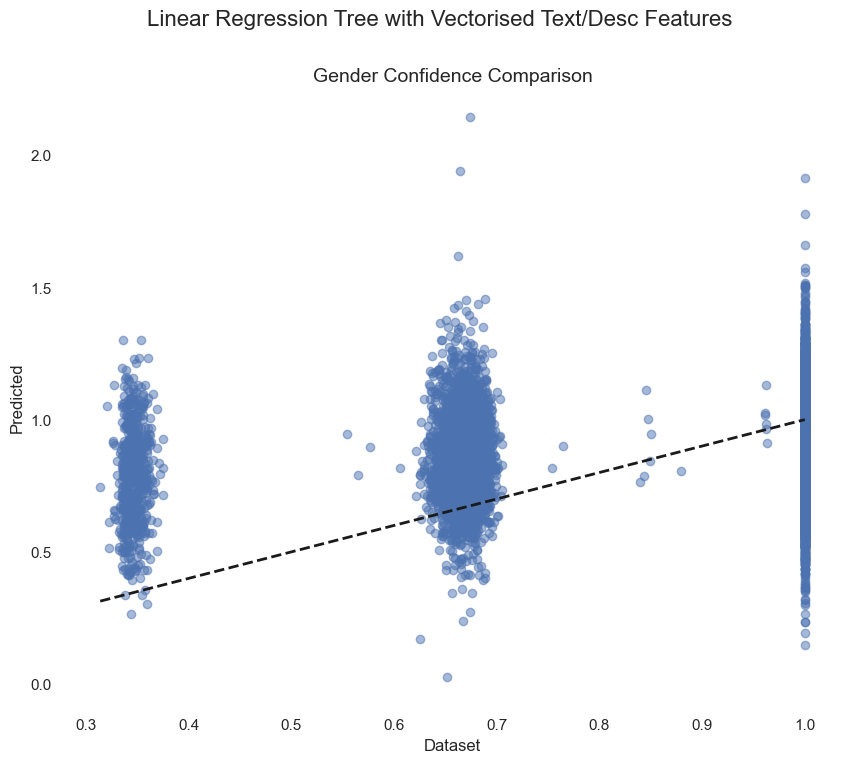

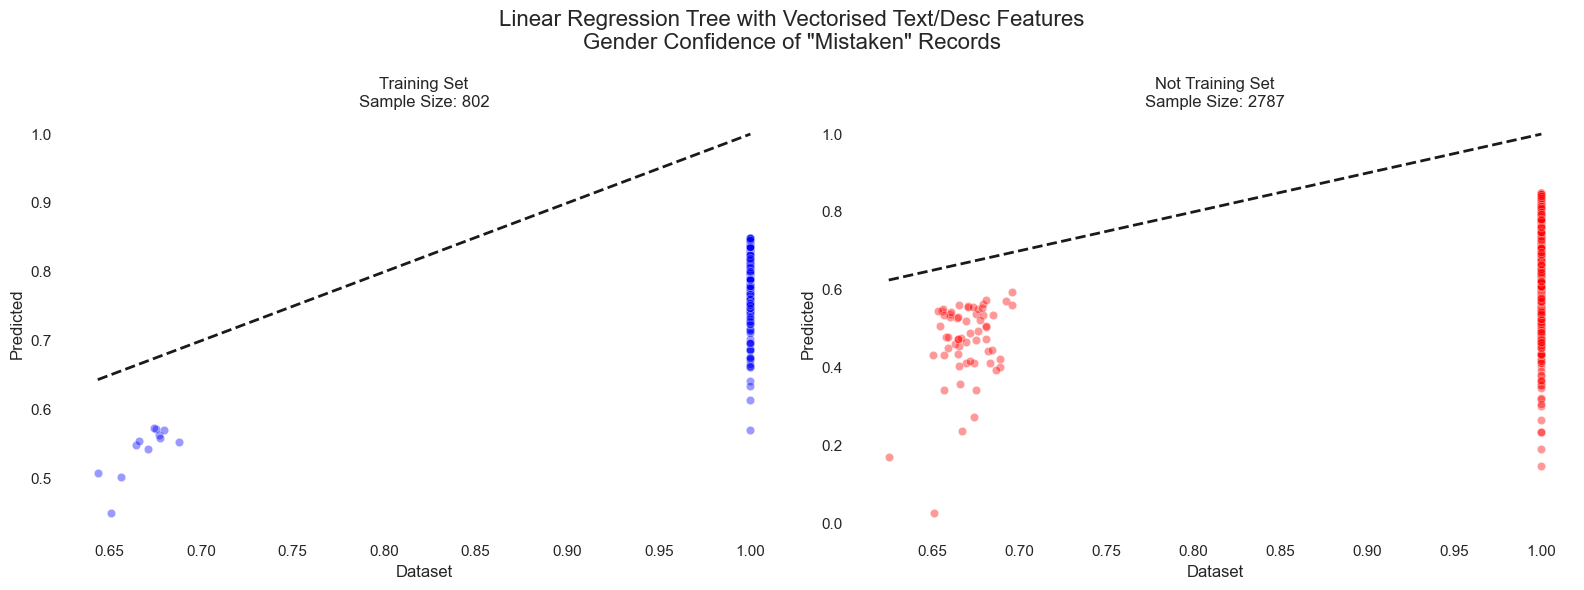


Linear Regression Tree without Vectorised Text/Desc Features
Mean Squared Error (Train): 0.0292
Mean Squared Error (Test): 0.0305
Mean Squared Error (Total): 0.0300


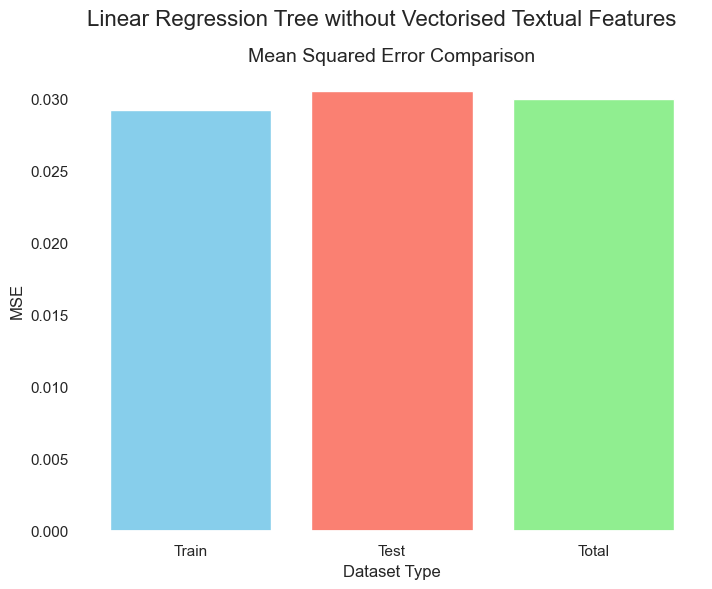

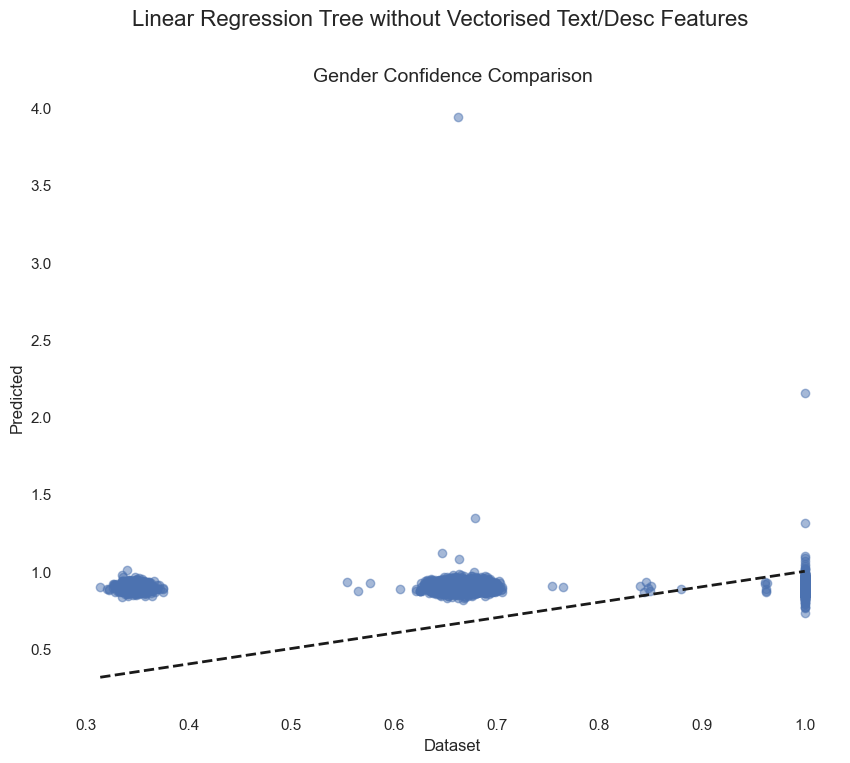

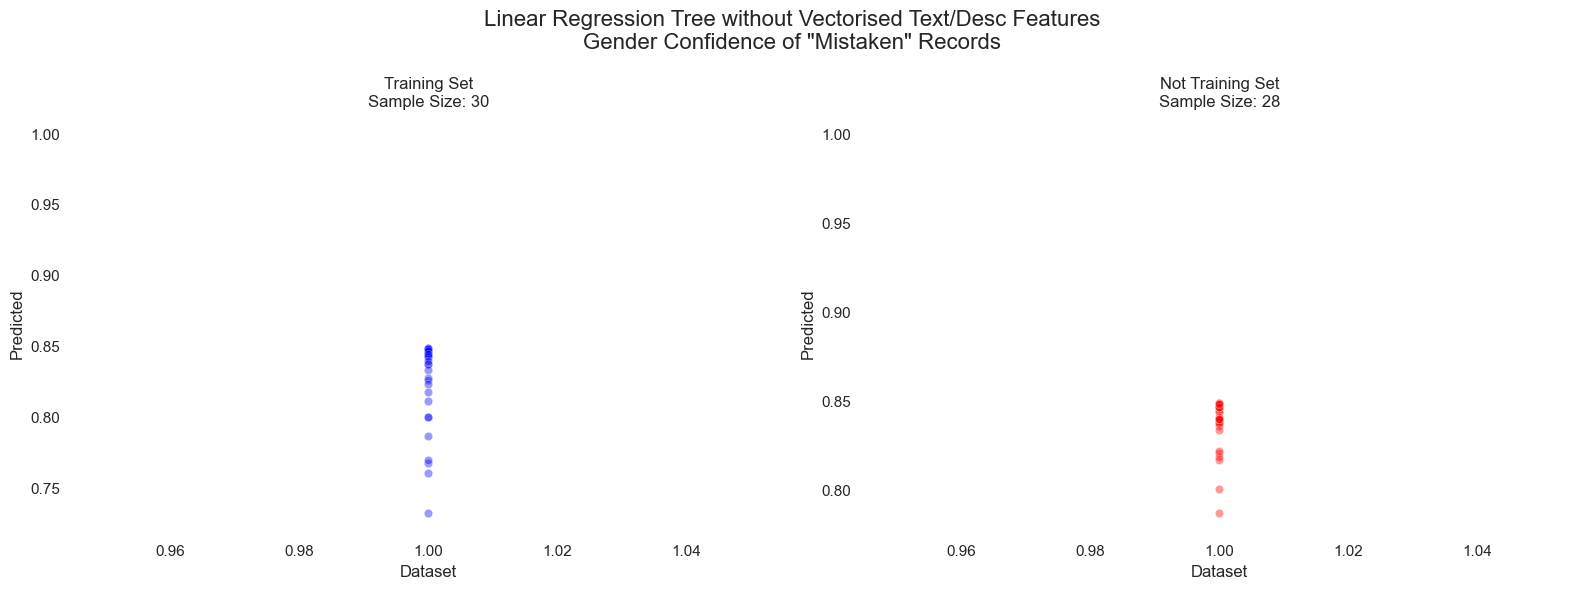

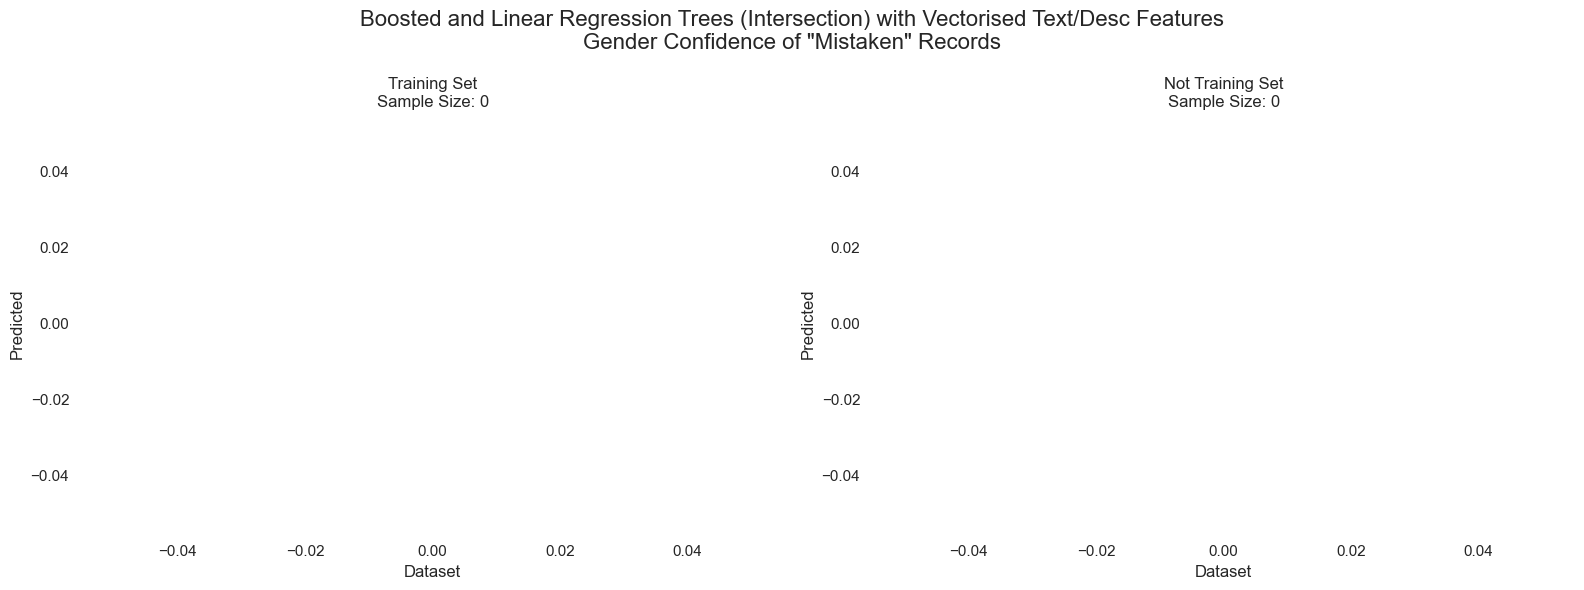

In [4]:
# =============================== REGRESSION ======================================
print()
print()
df_preprocessed_reg = df_preprocessed.copy()
y = df_preprocessed["gender:confidence"].reset_index(drop=True)
df_preprocessed_reg = df_preprocessed_reg.drop(['gender', "gender:confidence"], axis=1)

print()
print("=" * 50)
print('Boosted Regression Tree with Vectorised Text/Desc Features')
print("=" * 50)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed_reg, y, test_size=0.6, random_state=42)
boosted_reg = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
boosted_reg.fit(X_train, y_train)

# Make predictions
y_pred = boosted_reg.predict(X_test)
y_pred_train = boosted_reg.predict(X_train)
y_tot_pred = boosted_reg.predict(df_preprocessed_reg)

# Evaluate performance using Mean Squared Error
mse_test = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_total = mean_squared_error(y, y_tot_pred)

print(f"Mean Squared Error (Train): {mse_train:.4f}")
print(f"Mean Squared Error (Test): {mse_test:.4f}")
print(f"Mean Squared Error (Total): {mse_total:.4f}")

# PLOT MSE
labels = ['Train', 'Test', 'Total']
mse_values = [mse_train, mse_test, mse_total]
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.suptitle('Boosted Regression Tree with Vectorised Text/Desc Features', fontsize=16)
plt.title('Mean Squared Error Comparison', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('MSE')
plt.show()

# FEATURE IMPORTANCE
print()
print("Performing feature importance analysis...")
# Find column indices that start with 'desc_' and 'text_'
desc_columns = [i for i, col in enumerate(df_preprocessed_reg.columns) if col.startswith('desc_')]
text_columns = [i for i, col in enumerate(df_preprocessed_reg.columns) if col.startswith('text_')]
# Access the corresponding elements from the ndarray using the column indices
desc_array = boosted_reg.feature_importances_[desc_columns]
text_array = boosted_reg.feature_importances_[text_columns]
# Output the results
# print("desc_ column indices:", desc_columns)
# print("text_ column indices:", text_columns)
# print("desc_ array:\n", desc_array)
# print("text_ array:\n", text_array)
# Sum the values for desc_ and text_ columns
desc_sum = np.sum(boosted_reg.feature_importances_[desc_columns])
text_sum = np.sum(boosted_reg.feature_importances_[text_columns])
# Create a new DataFrame
new_data = {}
# Add the 'desc' and 'text' columns with the summed values
new_data['desc'] = [desc_sum]
new_data['text'] = [text_sum]
boosted_reg.feature_importances_
# Add the other feature columns that are not desc_ or text_
other_columns = [i for i in range(len(df_preprocessed_reg.columns)) if i not in desc_columns and i not in text_columns]
for i in other_columns:
    col_name = df_preprocessed_reg.columns[i]
    new_data[col_name] = [boosted_reg.feature_importances_[i]]
# Convert the new_data dictionary to a DataFrame
feature_importance = pd.DataFrame(new_data)
# Output the results
print(feature_importance)

# Plot feature importance
df_melted = feature_importance.melt(var_name='Feature', value_name='Importance in percentage')
df_melted = df_melted.sort_values(ascending=False, by="Importance in percentage")
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance in percentage', y='Feature', data=df_melted, palette='viridis')
plt.suptitle('Boosted Regression Tree with Vectorised Text/Desc Features', fontsize=16)
plt.title('Feature Importance Analysis', fontsize=14)
plt.show()


# preprocess dataset for plots with regression results
df_preprocessed_diff = df_preprocessed_reg.copy()
df_preprocessed_diff['difference'] = (y.to_numpy() - y_tot_pred)
df_preprocessed_diff["gender_confidence_pred"] = y_tot_pred
y_reset = y.reset_index(drop=True)
df_preprocessed_diff["gender:confidence"] = y_reset

# filtering out coloumns that might be false mistaken
misclassified_df_reg = df_preprocessed_diff[(df_preprocessed_diff["difference"] > 0.1) & (df_preprocessed_diff["gender_confidence_pred"] < 0.85)]
misclassified_df = df_preprocessed_diff[(df_preprocessed_diff["difference"] > 0.1) & (df_preprocessed_diff["gender_confidence_pred"] < 0.85)]
non_train_misclassify = misclassified_df[misclassified_df.index.isin(X_train.index)]
train_misclassify = misclassified_df[~misclassified_df.index.isin(X_train.index)]

# plotting these columns

def scatterplot_mistaken_points(misclassified_df, X_train, model):
    # Edit misclassified_df to include 'in X_train'
    misclassified_df["in X_train"] = misclassified_df.index.isin(X_train.index)
    # Create subsets for the two plots
    df_in_X_train = misclassified_df[misclassified_df["in X_train"]]
    df_not_in_X_train = misclassified_df[~misclassified_df["in X_train"]]
    # Set up the matplotlib figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    # Set the main title
    fig.suptitle(f'{model}\nGender Confidence of "Mistaken" Records', fontsize=16)
    # Plot 1: Points in X_train
    sns.scatterplot(data=df_in_X_train, x='gender:confidence', y='gender_confidence_pred', alpha=0.4, ax=axes[0], color='blue')
    axes[0].plot([df_in_X_train['gender:confidence'].min(), df_in_X_train['gender:confidence'].max()],
                 [df_in_X_train['gender:confidence'].min(), df_in_X_train['gender:confidence'].max()], 'k--', lw=2)
    axes[0].set_xlabel('Dataset')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'Training Set\nSample Size: {len(df_in_X_train)}')
    # Plot 2: Points not in X_train
    sns.scatterplot(data=df_not_in_X_train, x='gender:confidence', y='gender_confidence_pred', alpha=0.4, ax=axes[1], color='red')
    axes[1].plot([df_not_in_X_train['gender:confidence'].min(), df_not_in_X_train['gender:confidence'].max()],
                 [df_not_in_X_train['gender:confidence'].min(), df_not_in_X_train['gender:confidence'].max()], 'k--', lw=2)
    axes[1].set_xlabel('Dataset')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title(f'Not Training Set\nSample Size: {len(df_not_in_X_train)}')
    plt.tight_layout()
    plt.show()

def scatter_plot(y, y_tot_pred, model):
    # Plotting more results results
    plt.figure(figsize=(10, 8))
    plt.scatter(y, y_tot_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.suptitle(model, fontsize=16)
    plt.title('Gender Confidence Comparison', fontsize=14)
    plt.show()

scatterplot_mistaken_points(misclassified_df, X_train, "Boosted Regression Tree with Vectorised Text/Desc Features")
scatter_plot(y, y_tot_pred, "Boosted Regression Tree with Vectorised Text/Desc Features")

# ==============================analyze without text features=============================================
columns_to_drop = [col for col in df_preprocessed_reg.columns if col.startswith(('desc_', 'text_'))]
df_preprocessed_non_text = df_preprocessed_reg.drop(columns=columns_to_drop)
df_preprocessed_non_text2 = df_preprocessed_non_text.copy()
print(df_preprocessed_non_text)

print()
print("=" * 50)
print('Boosted Regression Tree without Vectorised Text/Desc Features')
print("=" * 50)

boosted_reg_non_text = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
# Split the dataset into training and testing sets
X_train_non_text, X_test_non_text, y_train_non_text, y_test_non_text = train_test_split(df_preprocessed_non_text, y, test_size=0.6, random_state=42)
# Fit the model
boosted_reg_non_text.fit(X_train_non_text, y_train_non_text)
# Make predictions
y_pred = boosted_reg_non_text.predict(X_test_non_text)
y_pred_train = boosted_reg_non_text.predict(X_train_non_text)

# Evaluate performance using Mean Squared Error
mse_test = mean_squared_error(y_test_non_text, y_pred)
mse_train = mean_squared_error(y_train_non_text, y_pred_train)
mse_total = mean_squared_error(y, y_tot_pred)
y_tot_pred = boosted_reg_non_text.predict(df_preprocessed_non_text)

print(f"Mean Squared Error (Train): {mse_train:.4f}")
print(f"Mean Squared Error (Test): {mse_test:.4f}")
print(f"Mean Squared Error (Total): {mse_total:.4f}")

# PLOT MSE
labels = ['Train', 'Test', 'Total']
mse_values = [mse_train, mse_test, mse_total]
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.suptitle('Boosted Regression Tree without Vectorised Text/Desc Features', fontsize=16)
plt.title('Mean Squared Error Comparison', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('MSE')
plt.show()

# Get feature importances and plot from the model
print()
print("Performing feature importance analysis...")
feature_importances = boosted_reg_non_text.feature_importances_
column_names = X_train_non_text.columns
feature_importance_df = pd.DataFrame({
    'Feature': column_names,
    'Importance in percentage': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance in percentage', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance in percentage', y='Feature', data=feature_importance_df, palette='viridis')
plt.suptitle('Boosted Regression Tree without Vectorised Text/Desc Features', fontsize=16)
plt.title('Feature Importance Analysis', fontsize=14)
plt.show()

# adding the dataset gender confidence
df_preprocessed_non_text["gender_confidence_pred"] = y_tot_pred
y_reset = y.reset_index(drop=True)
df_preprocessed_non_text["gender:confidence"] = y_reset

# Inspecting coulumns that could be suspicous
df_preprocessed_non_text["difference"] = y.to_numpy() - y_tot_pred
misclassified_df = df_preprocessed_non_text[(df_preprocessed_non_text["difference"] > 0.1) & (df_preprocessed_non_text["gender_confidence_pred"] < 0.85)]
non_train_misclassify = misclassified_df[misclassified_df.index.isin(X_train_non_text.index)]
train_misclassify = misclassified_df[~misclassified_df.index.isin(X_train_non_text.index)]
scatterplot_mistaken_points(misclassified_df, X_train_non_text, "Boosted Regression Tree without Vectorised Text/Desc Features")
scatter_plot(y, y_tot_pred, "Boosted Regression Tree without Vectorised Text/Desc Features")

# ====================================Analyzing with a linear regression (Least Squares Implementation)====================

print()
print("=" * 50)
print('Linear Regression Tree with Vectorised Text/Desc Features')
print("=" * 50)

X_train_lin = sm.add_constant(X_train)
X_test_lin = sm.add_constant(X_test)
df_preprocessed_lin = sm.add_constant(df_preprocessed_reg)
model = sm.OLS(y_train, X_train_lin)  # Ordinary least squares (unregularized)
results = model.fit()

# run predictions
y_lin_pred = results.predict(X_test_lin)
y_lin_tot_pred = results.predict(df_preprocessed_lin)
y_lin_train = results.predict(X_train_lin)

# Evaluate performance using Mean Squared Error
mse_test = mean_squared_error(y_test, y_lin_pred)
mse_total = mean_squared_error(y, y_lin_tot_pred)
mse_train = mean_squared_error(y_train, y_lin_train)

print(f"Mean Squared Error (Train): {mse_train:.4f}")
print(f"Mean Squared Error (Test): {mse_test:.4f}")
print(f"Mean Squared Error (Total): {mse_total:.4f}")

# PLOT MSE
labels = ['Train', 'Test', 'Total']
mse_values = [mse_train, mse_test, mse_total]
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.suptitle('Linear Regression Tree with Vectorised Textual Features', fontsize=16)
plt.title('Mean Squared Error Comparison', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('MSE')
plt.show()

# final preprocess
df_preprocessed_lin["difference"] = y.to_numpy() - y_lin_tot_pred
y_reset = y.reset_index(drop=True)
df_preprocessed_lin["gender:confidence"] = y
df_preprocessed_lin["gender_confidence_pred"] = y_lin_tot_pred


# identify mistaken users
misclassified_df = df_preprocessed_lin[(df_preprocessed_lin["difference"] > 0.1) & (df_preprocessed_lin["gender_confidence_pred"] < 0.85)]
non_train_misclassify = misclassified_df[misclassified_df.index.isin(X_train_lin.index)]
train_misclassify = misclassified_df[~misclassified_df.index.isin(X_train_lin.index)]

misclassified_df_lin_reg = misclassified_df.copy()

scatter_plot(y, y_lin_tot_pred, "Linear Regression Tree with Vectorised Text/Desc Features")
scatterplot_mistaken_points(misclassified_df, X_train_lin, "Linear Regression Tree with Vectorised Text/Desc Features")

#================================Lin reg without text=======================================================
#================================Linear regression without text features============================
print()
print("=" * 50)
print('Linear Regression Tree without Vectorised Text/Desc Features')
print("=" * 50)

X_train_lin = sm.add_constant(X_train_non_text)
X_test_lin = sm.add_constant(X_test_non_text)
df_preprocessed_lin = sm.add_constant(df_preprocessed_non_text2)
model = sm.OLS(y_train, X_train_lin)  # Ordinary least squares (unregularized)
results = model.fit()

#run predictions
y_lin_pred = results.predict(X_test_lin)
y_lin_tot_pred = results.predict(df_preprocessed_lin)
y_lin_train = results.predict(X_train_lin)

# Evaluate performance using Mean Squared Error
mse_test = mean_squared_error(y_test, y_lin_pred)
mse_total = mean_squared_error(y, y_lin_tot_pred)
mse_train = mean_squared_error(y_train, y_lin_train)

print(f"Mean Squared Error (Train): {mse_train:.4f}")
print(f"Mean Squared Error (Test): {mse_test:.4f}")
print(f"Mean Squared Error (Total): {mse_total:.4f}")

# PLOT MSE
labels = ['Train', 'Test', 'Total']
mse_values = [mse_train, mse_test, mse_total]
plt.figure(figsize=(8, 6))
plt.bar(labels, mse_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.suptitle('Linear Regression Tree without Vectorised Textual Features', fontsize=16)
plt.title('Mean Squared Error Comparison', fontsize=14)
plt.xlabel('Dataset Type')
plt.ylabel('MSE')
plt.show()

#final preprocess
df_preprocessed_lin["difference"] = y.to_numpy() - y_lin_tot_pred
y_reset = y.reset_index(drop=True)
df_preprocessed_lin["gender:confidence"] = y
df_preprocessed_lin["gender_confidence_pred"] = y_lin_tot_pred


#identify mistaken users
misclassified_df = df_preprocessed_lin[(df_preprocessed_lin["difference"] > 0.1) & (df_preprocessed_lin["gender_confidence_pred"] < 0.85)]
non_train_misclassify = misclassified_df[misclassified_df.index.isin(X_train_lin.index)]
train_misclassify = misclassified_df[~misclassified_df.index.isin(X_train_lin.index)]

scatter_plot(y, y_lin_tot_pred, "Linear Regression Tree without Vectorised Text/Desc Features")
scatterplot_mistaken_points(misclassified_df, X_train_lin, "Linear Regression Tree without Vectorised Text/Desc Features")



# ================================Identity final mistaken samples====================================
common_samples = misclassified_df_reg.index.intersection(misclassified_df.index)
common_df = misclassified_df.loc[common_samples]

scatterplot_mistaken_points(common_df, X_train_lin, "Boosted and Linear Regression Trees (Intersection) with Vectorised Text/Desc Features")

## CLASSIFICATION



---- CLASSIFICATION ----
Accuracy Score:  0.6242038216560509
Confusion Matrix:
 [[661 470 136]
 [284 932 102]
 [250 174 759]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.52      0.54      1267
           1       0.59      0.71      0.64      1318
           2       0.76      0.64      0.70      1183

    accuracy                           0.62      3768
   macro avg       0.64      0.62      0.63      3768
weighted avg       0.63      0.62      0.62      3768


XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      1267
           1       0.61      0.65      0.63      1318
           2       0.72      0.67      0.69      1183

    accuracy                           0.62      3768
   macro avg       0.63      0.62      0.62      3768
weighted avg       0.62      0.62      0.62      3768

Accuracy: 0.6220806794055201
[LightGBM] [Info] Auto-choosi

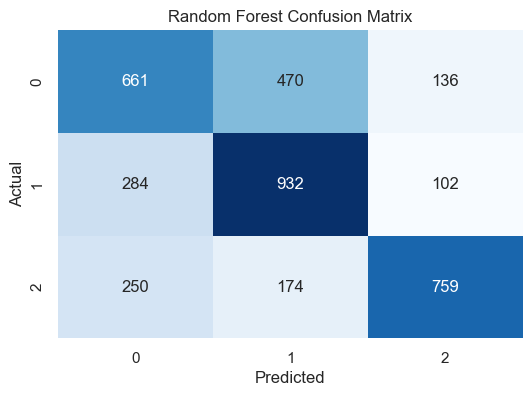

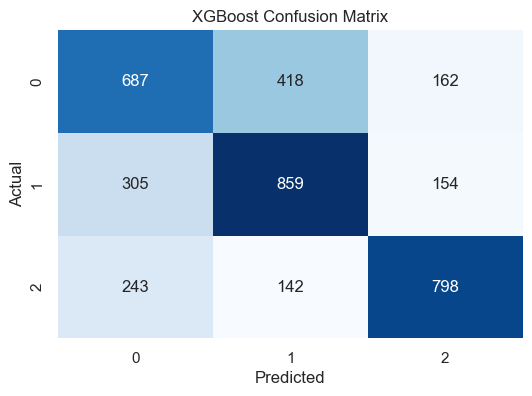

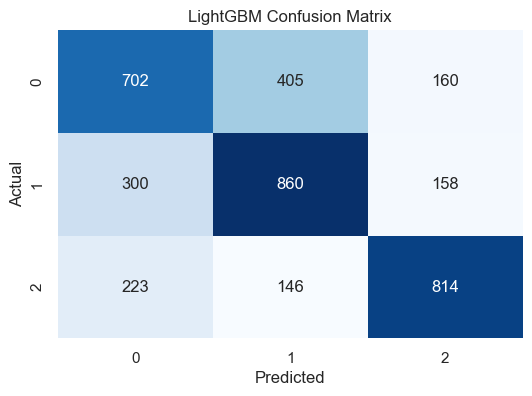

Combined Classification Report:
            precision    recall  f1-score      support          model
0           0.553138  0.521705  0.536962  1267.000000  Random Forest
1           0.591371  0.707132  0.644091  1318.000000  Random Forest
2           0.761284  0.641589  0.696330  1183.000000  Random Forest
accuracy    0.624204  0.624204  0.624204     0.624204  Random Forest
macro avg   0.635264  0.623475  0.625794  3768.000000  Random Forest
Filtered Report for Precision, Recall, and F1-Score:
   index  precision    recall  f1-score  support          model
0     0   0.553138  0.521705  0.536962   1267.0  Random Forest
1     1   0.591371  0.707132  0.644091   1318.0  Random Forest
2     0   0.556275  0.542226  0.549161   1267.0        XGBoost
3     1   0.605356  0.651745  0.627695   1318.0        XGBoost
4     0   0.573061  0.554065  0.563403   1267.0       LightGBM
Data for precision:
  index  precision          model
0     0   0.553138  Random Forest
1     1   0.591371  Random Forest

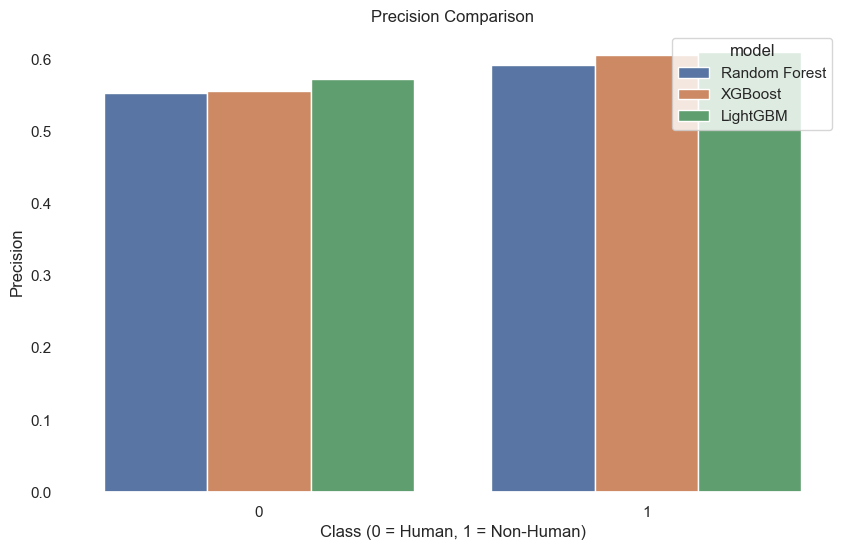

Data for recall:
  index    recall          model
0     0  0.521705  Random Forest
1     1  0.707132  Random Forest
2     0  0.542226        XGBoost
3     1  0.651745        XGBoost
4     0  0.554065       LightGBM
5     1  0.652504       LightGBM


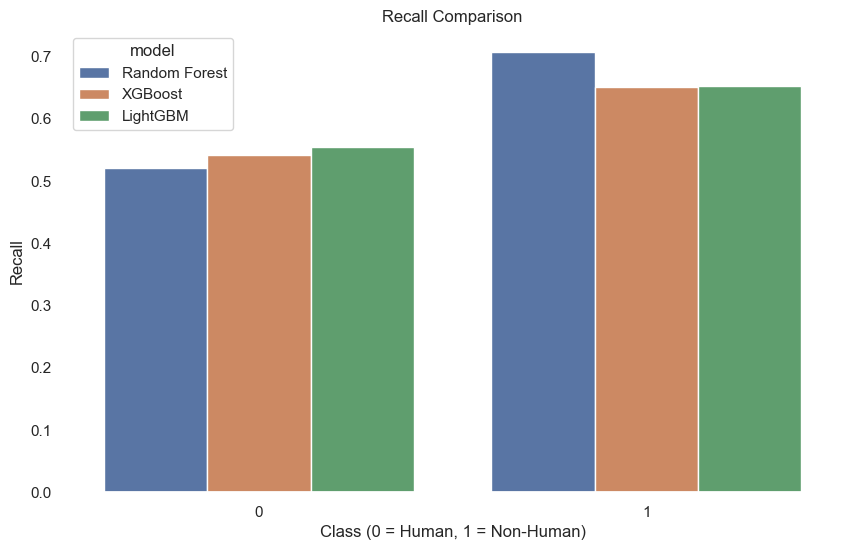

Data for f1-score:
  index  f1-score          model
0     0  0.536962  Random Forest
1     1  0.644091  Random Forest
2     0  0.549161        XGBoost
3     1  0.627695        XGBoost
4     0  0.563403       LightGBM
5     1  0.630267       LightGBM


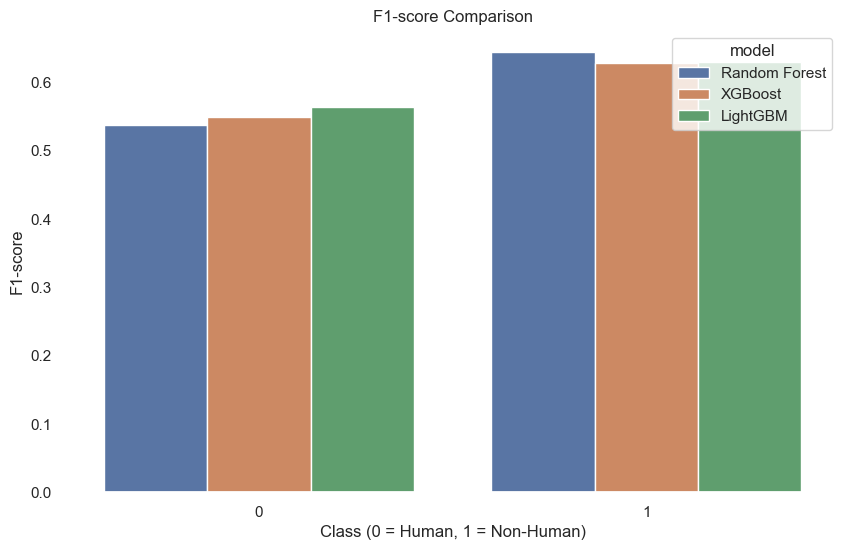

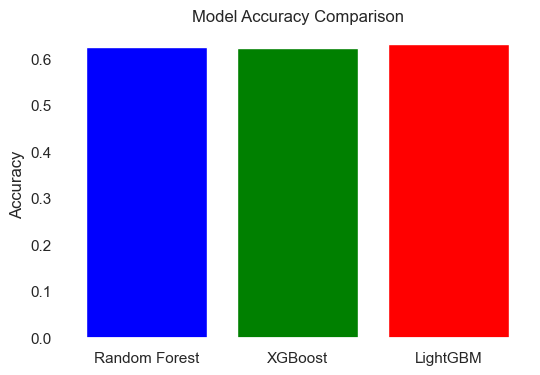

In [5]:
# ============================== CLASSIFICATION ==============================

print()
print()
print('---- CLASSIFICATION ----')
# Features and target
X = df_preprocessed.drop(columns=['gender'])  # Assuming 'gender' is the target variable
y = df_preprocessed['gender']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the performance
print("Accuracy Score: ", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("\nXGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Initialize LightGBM classifier
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42)

# Fit the model
lgb_clf.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_clf.predict(X_test)

# Evaluation
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# Helper function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# Helper function to extract and display classification report with model name
def get_classification_report(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df['model'] = model_name
    return df

# Random Forest Confusion Matrix and Classification Report
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
rf_report = get_classification_report(y_test, y_pred_rf, "Random Forest")

# XGBoost Confusion Matrix and Classification Report
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
xgb_report = get_classification_report(y_test, y_pred_xgb, "XGBoost")

# LightGBM Confusion Matrix and Classification Report
plot_confusion_matrix(y_test, y_pred_lgb, "LightGBM")
lgb_report = get_classification_report(y_test, y_pred_lgb, "LightGBM")

# Combine all reports
combined_report = pd.concat([rf_report, xgb_report, lgb_report])

# Debugging Step: Check the combined report structure
print("Combined Classification Report:\n", combined_report.head())

# Filter out rows for precision, recall, and f1-score
combined_report_filtered = combined_report[
    combined_report.index.isin(['0', '1'])  # Filter for the classes
].reset_index()

# Debugging Step: Check the filtered report structure
print("Filtered Report for Precision, Recall, and F1-Score:\n", combined_report_filtered.head())

# Plot Precision, Recall, and F1-Score for each model
metrics = ['precision', 'recall', 'f1-score']

for metric in metrics:
    # Debugging Step: Filter for specific metric
    print(f"Data for {metric}:")
    print(combined_report_filtered[['index', metric, 'model']])

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="index",
        y=metric,
        hue="model",
        data=combined_report_filtered[['index', metric, 'model']]
    )
    plt.title(f'{metric.capitalize()} Comparison')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Class (0 = Human, 1 = Non-Human)')
    plt.show()

# Accuracy comparison
accuracies = {
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'XGBoost': accuracy_score(y_test, y_pred_xgb),
    'LightGBM': accuracy_score(y_test, y_pred_lgb)
}

plt.figure(figsize=(6, 4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

## ASSOCIATION RULES



---- ASSOCIATION RULES ----
                       antecedents                     consequents  \
0                    (high_tweets)                (high_favorites)   
1                 (high_favorites)                   (high_tweets)   
2                   (tweet_recent)                (high_favorites)   
3                 (high_favorites)                  (tweet_recent)   
4                   (tweet_recent)                   (high_tweets)   
5                    (high_tweets)                  (tweet_recent)   
6                   (tweet_recent)                (profile_recent)   
7                 (profile_recent)                  (tweet_recent)   
8      (tweet_recent, high_tweets)                (high_favorites)   
9    (high_favorites, high_tweets)                  (tweet_recent)   
10  (tweet_recent, high_favorites)                   (high_tweets)   
11                   (high_tweets)  (tweet_recent, high_favorites)   
12                  (tweet_recent)   (high_favorites, high_t

C:\Users\Owner\uowMaster\subject\946\venv_bda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


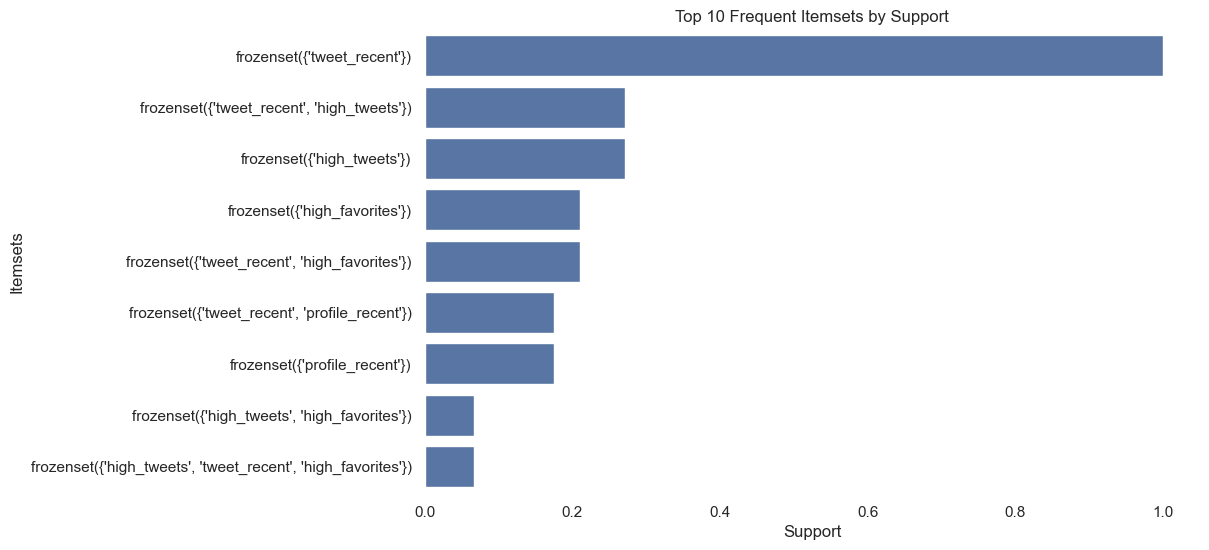

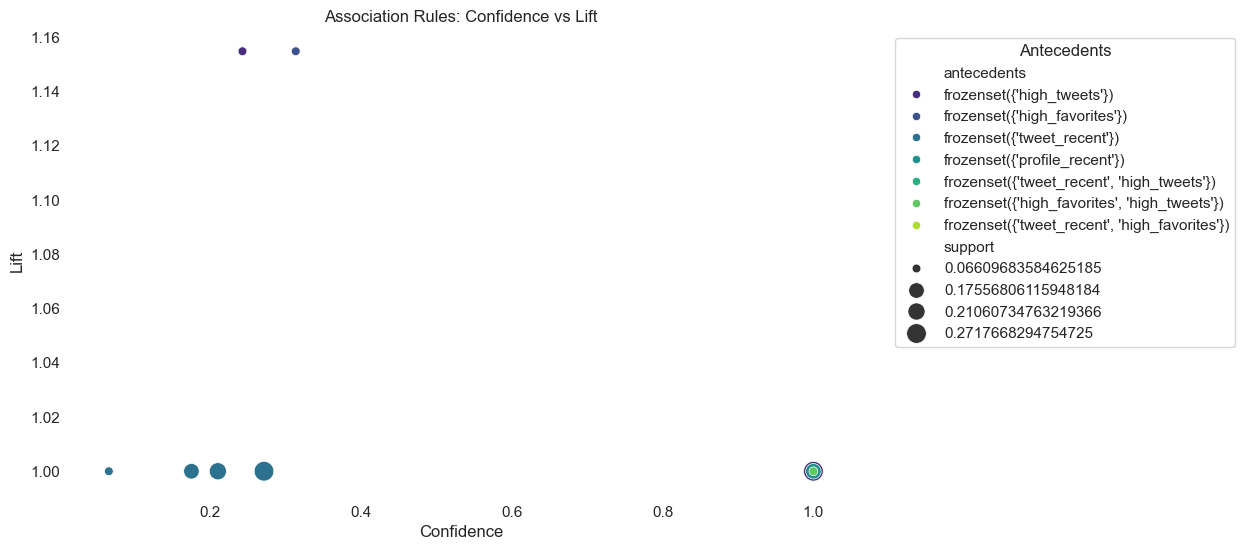

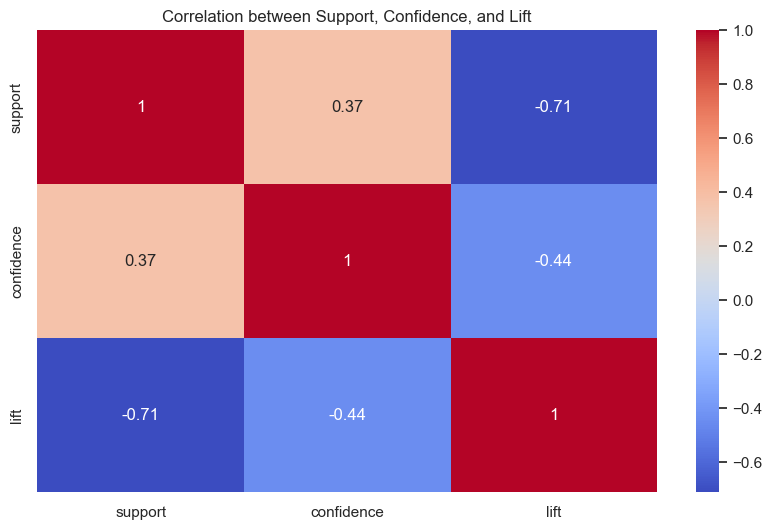

In [6]:
# ============================== ASSOCIATION RULES ==============================
print()
print()
print('---- ASSOCIATION RULES ----')
# Binarize numeric columns
df_asso['high_favorites'] = df_asso['favorites_per_day'] > df_asso['favorites_per_day'].mean()
df_asso['high_retweets'] = df_asso['retweets_per_day'] > df_asso['retweets_per_day'].mean()
df_asso['high_tweets'] = df_asso['tweets_per_day'] > df_asso['tweets_per_day'].mean()

# Binarize year columns (profile_created_year and tweet_created_year)
# Example: Set threshold year as 2015
df_asso['profile_recent'] = df_asso['profile_created_year'] >= 2015
df_asso['tweet_recent'] = df_asso['tweet_created_year'] >= 2015

# Select only the binary columns
df_apriori = df_asso[['high_favorites', 'high_retweets', 'high_tweets',
                              'profile_recent', 'tweet_recent',
                              'tweet_location_encoded', 'user_timezone_encoded']]

# Convert all columns to int (0 or 1)
df_apriori = df_apriori.astype(int)

# Apply Apriori
frequent_itemsets = apriori(df_apriori, min_support=0.05, use_colnames=True)

# Generate Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the rules
print(rules)


top_frequent_itemsets = frequent_itemsets.nlargest(10, 'support')

plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=top_frequent_itemsets)
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

# ---------------------------
# Visualization 2: Scatter Plot of Association Rules by Confidence and Lift
# ---------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='confidence', y='lift', size='support', data=rules, hue='antecedents', palette='viridis', sizes=(40, 200))
plt.title('Association Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.legend(title='Antecedents', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ---------------------------
# Visualization 3: Heatmap of Support, Confidence, and Lift
# ---------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(rules[['support', 'confidence', 'lift']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Support, Confidence, and Lift')
plt.show()

## AMENDMENT



---- AMENDMENT ----
Amendment Summary Report
Total records processed: 3682
Number of records amended: 92
Percentage of records amended: 2.50%

Gender Distribution (%):
------------------------
Category    Mistaken    Amended
1            35.99        34.95
2            33.49        34.71
0            30.53        30.34

Distribution Changes:
---------------------
1: -1.03%
2: +1.22%
0: -0.19%


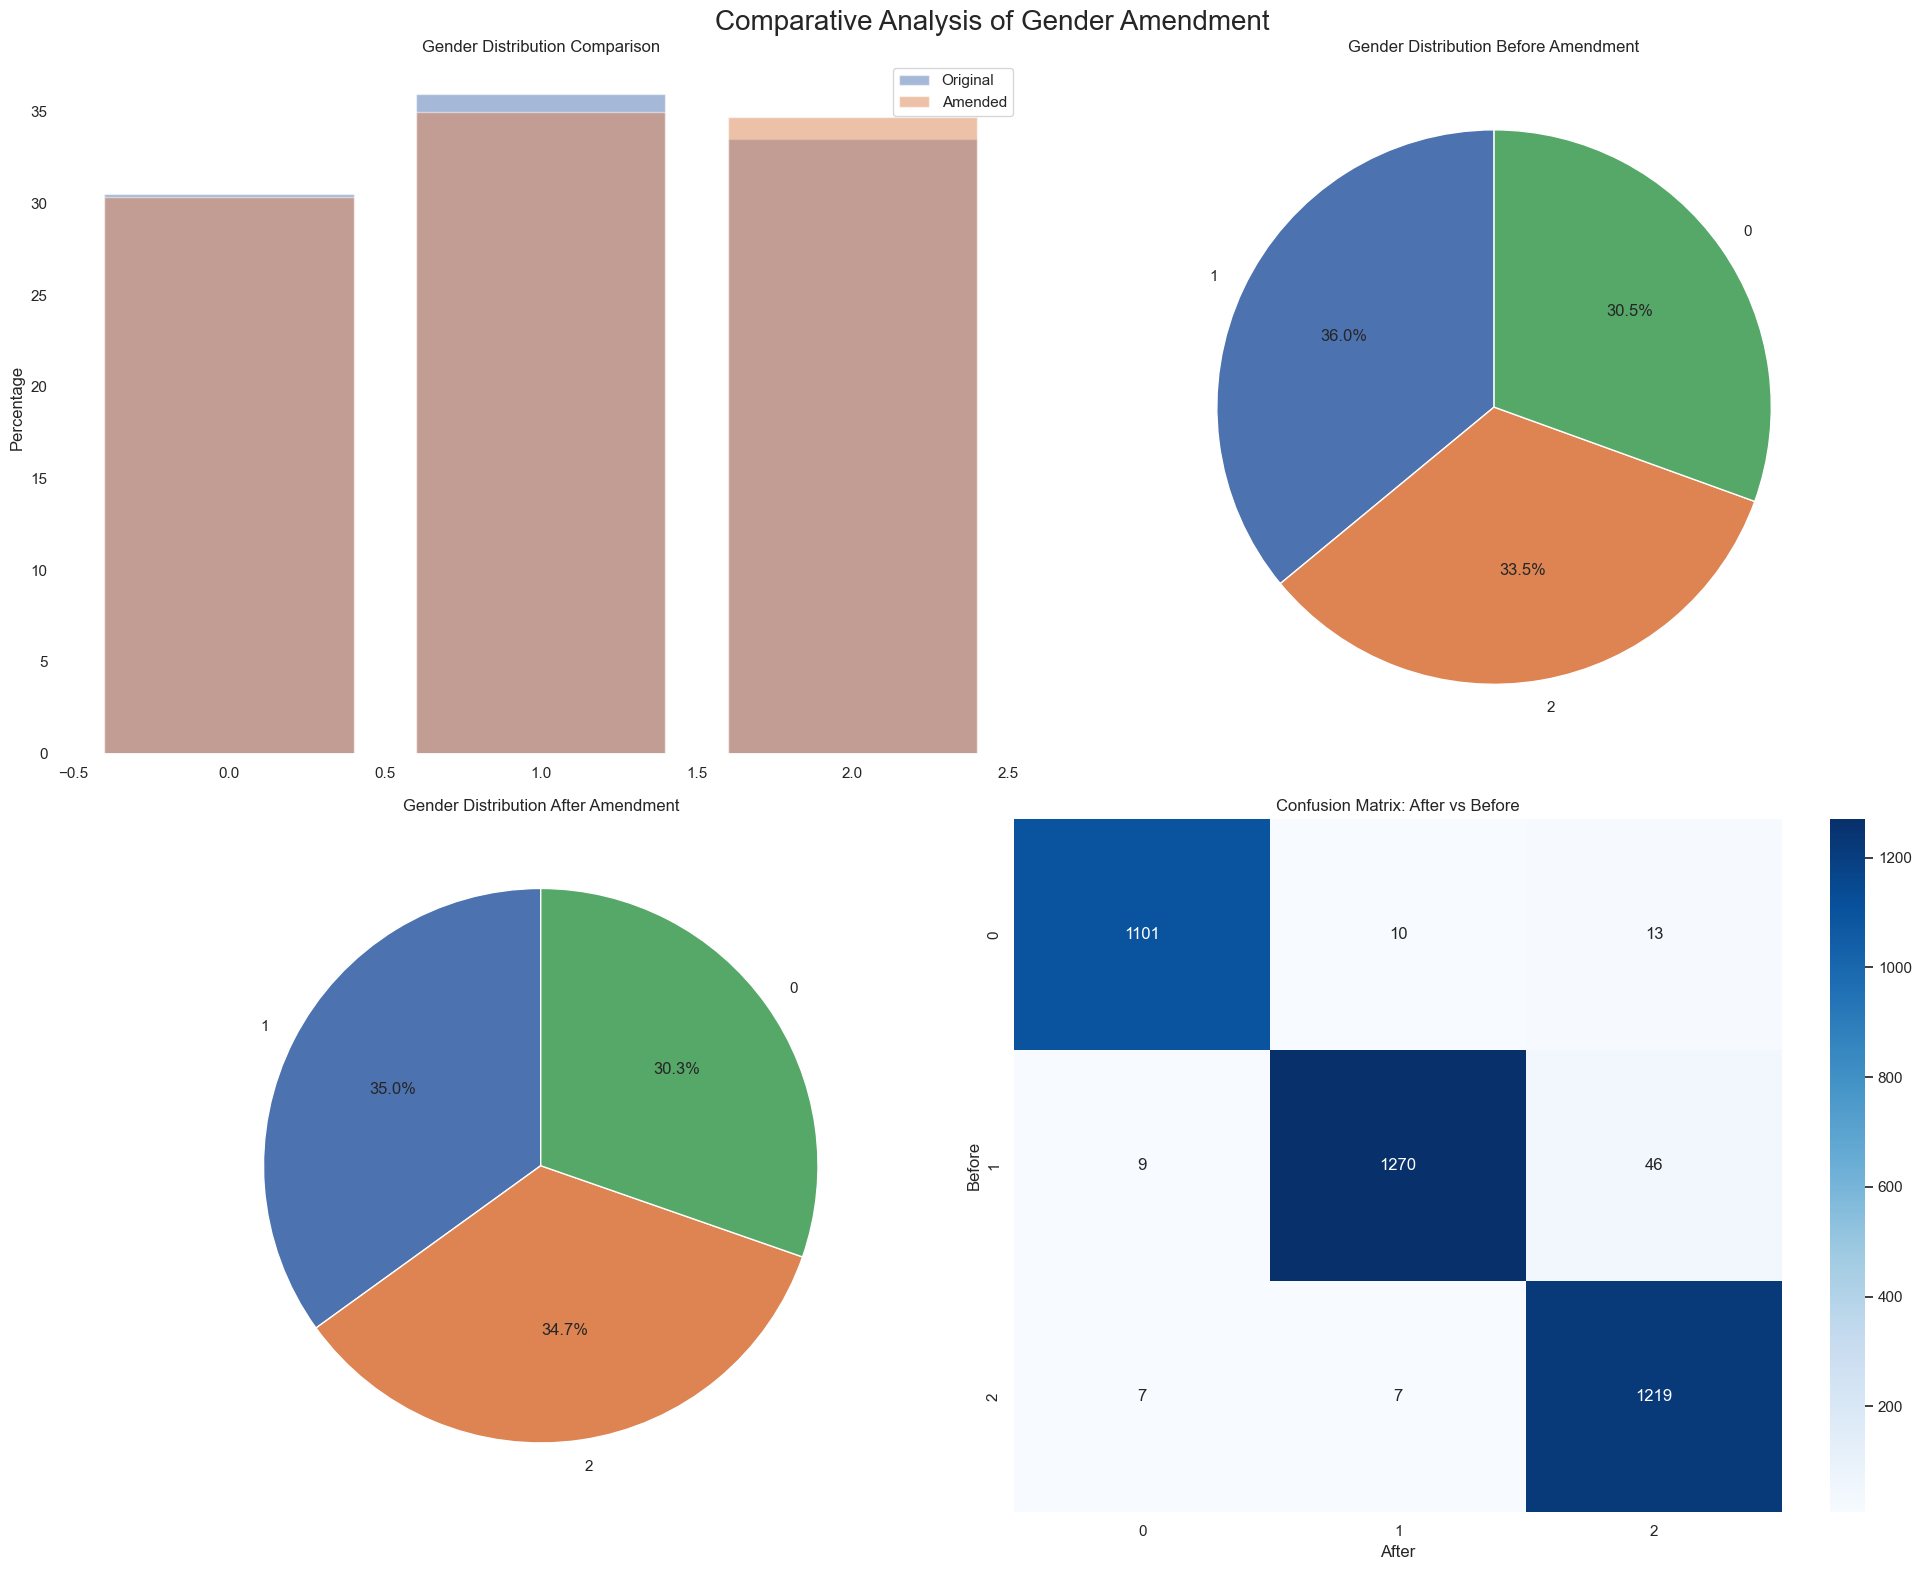

Visualizations have been saved as 'gender_amendment_analysis.png'


In [9]:
# ============================== AMENDMENT ==============================
print()
print()
print('---- AMENDMENT ----')

mistaken_index = misclassified_df_reg.index.union(misclassified_df_lin_reg.index)
df_truth = df_preprocessed.copy()
df_mistaken = df_preprocessed.loc[mistaken_index].copy()
df_amended = df_mistaken.copy()
vectorized_features = [col for col in df_truth.columns if col.startswith('desc_') or col.startswith('text_')]
df_truth_vectors = df_truth[vectorized_features]
df_mistaken_vectors = df_mistaken[vectorized_features]

similarities = cosine_similarity(df_mistaken_vectors, df_truth_vectors)
best_matches_indices = similarities.argmax(axis=1)
df_amended['gender'] = df_truth.loc[best_matches_indices, 'gender'].values

## Comparative Analysis

# Calculate the number of changes made
num_changes = (df_amended['gender'] != df_mistaken['gender']).sum()

# Calculate the percentage of records amended
percent_amended = (num_changes / len(df_amended)) * 100

## Impact on Statistics

# Function to calculate gender distribution
def gender_distribution(df):
    return df['gender'].value_counts(normalize=True) * 100

# Calculate gender distributions
original_dist = gender_distribution(df_mistaken)
amended_dist = gender_distribution(df_amended)

# Calculate the difference in distributions
dist_difference = amended_dist - original_dist

## Summary Report

print("Amendment Summary Report")
print("=======================")
print(f"Total records processed: {len(df_amended)}")
print(f"Number of records amended: {num_changes}")
print(f"Percentage of records amended: {percent_amended:.2f}%")
print("\nGender Distribution (%):")
print("------------------------")
print("Category    Mistaken    Amended")
for category in original_dist.index:
    print(f"{category:<12} {original_dist.get(category, 0):.2f}        {amended_dist.get(category, 0):.2f}")

print("\nDistribution Changes:")
print("---------------------")
for category in dist_difference.index:
    print(f"{category}: {dist_difference[category]:+.2f}%")

## Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle("Comparative Analysis of Gender Amendment", fontsize=20)

## 1. Bar plot: Gender Distribution Comparison
axs[0, 0].bar(original_dist.index, original_dist.values, alpha=0.5, label='Original')
axs[0, 0].bar(amended_dist.index, amended_dist.values, alpha=0.5, label='Amended')
axs[0, 0].set_title("Gender Distribution Comparison")
axs[0, 0].set_ylabel("Percentage")
axs[0, 0].legend()

## 2. Pie charts: Before and After Amendment
def plot_pie(ax, data, title):
    ax.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(title)

plot_pie(axs[0, 1], original_dist, "Gender Distribution Before Amendment")
plot_pie(axs[1, 0], amended_dist, "Gender Distribution After Amendment")

## 3. Heatmap: Confusion Matrix
cm = confusion_matrix(df_mistaken['gender'], df_amended['gender'], labels=df_mistaken['gender'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_mistaken['gender'].unique(), 
            yticklabels=df_mistaken['gender'].unique(), ax=axs[1, 1])
axs[1, 1].set_title("Confusion Matrix: After vs Before")
axs[1, 1].set_xlabel("After")
axs[1, 1].set_ylabel("Before")

## Adjust layout and save
plt.tight_layout()
plt.savefig('gender_amendment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Visualizations have been saved as 'gender_amendment_analysis.png'")